This script reproduces the [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html) by the HDDM (0.9.0) in this docker image.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import hddm
import kabuki
print("HDDM's version is: ", hddm.__version__)
print("kabuki's version is: ", kabuki.__version__)

HDDM's version is:  0.8.0
kabuki's version is:  0.6.5


## Loading data

In [3]:
# find the directory of "cavanagh_theta_nn.csv"
print(hddm.__file__)

/opt/conda/lib/python3.8/site-packages/hddm/__init__.py


In [4]:
!head /opt/conda/lib/python3.8/site-packages/hddm/examples/cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


In [5]:
data = hddm.load_csv('/opt/conda/lib/python3.8/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


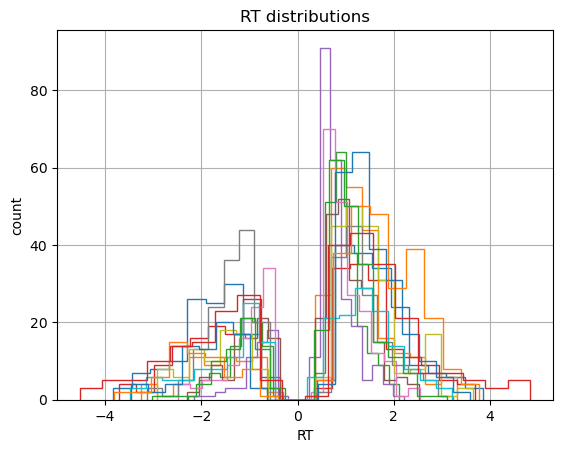

In [6]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Check number of trials of each condition for each participant.

In [7]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

## Fitting a hierarchical model

In [8]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
m1 = hddm.HDDM(data)
# find a good starting point which helps with the convergence.
m1.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m1.sample(2000, burn=500)

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

 [-----------------100%-----------------] 2000 of 2000 complete in 37.2 sec

In [9]:
stats = m1.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.980001,0.100993,1.790943,1.913655,1.975719,2.040983,2.190129,0.003194
a_std,0.34417,0.083723,0.224848,0.288244,0.326874,0.384707,0.549796,0.003139
a_subj.0,2.201272,0.063195,2.080797,2.159976,2.198467,2.244337,2.330745,0.002037
a_subj.1,2.121363,0.067579,1.994451,2.071307,2.119981,2.167287,2.261609,0.002348


Plotting a
Plotting a_std
Plotting v
Plotting t


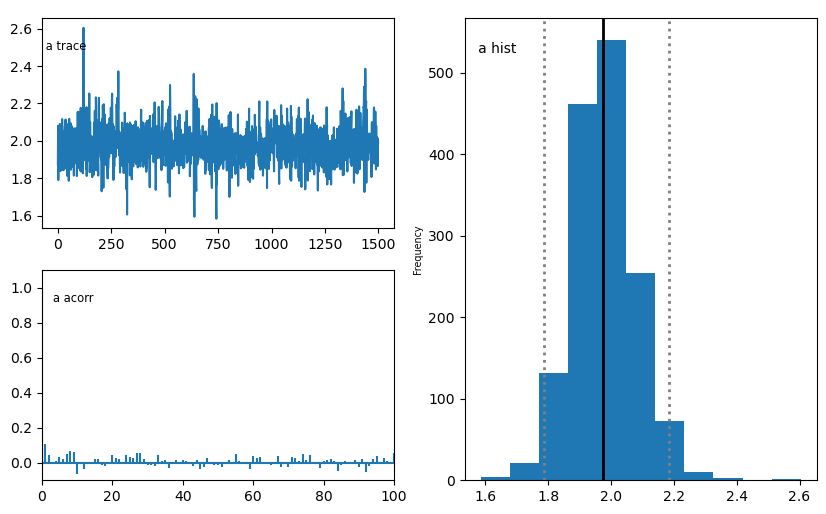

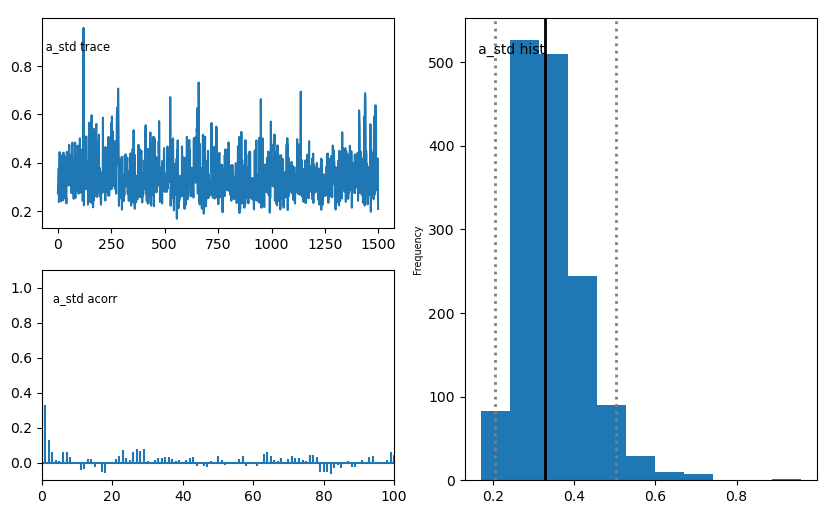

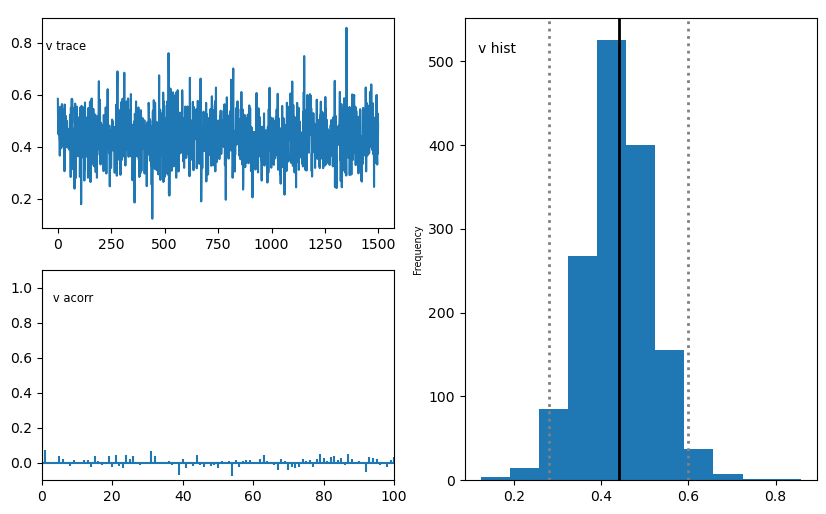

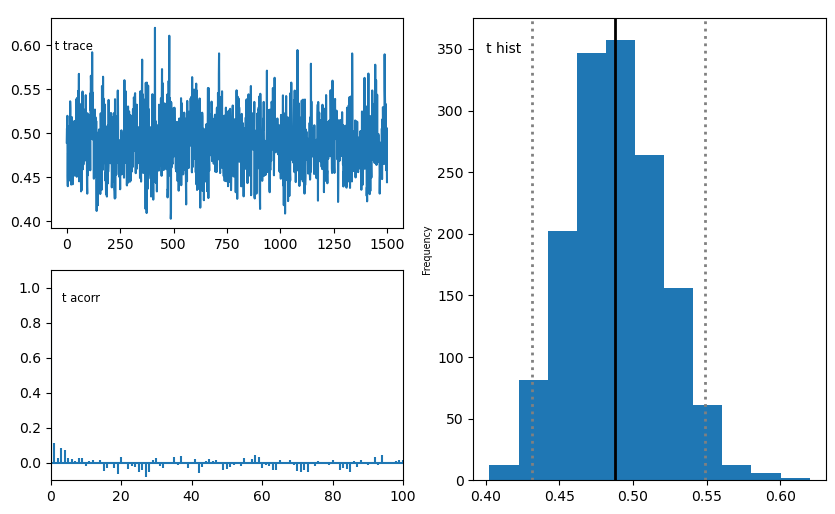

In [10]:
m1.plot_posteriors(['a', 't', 'v', 'a_std'])

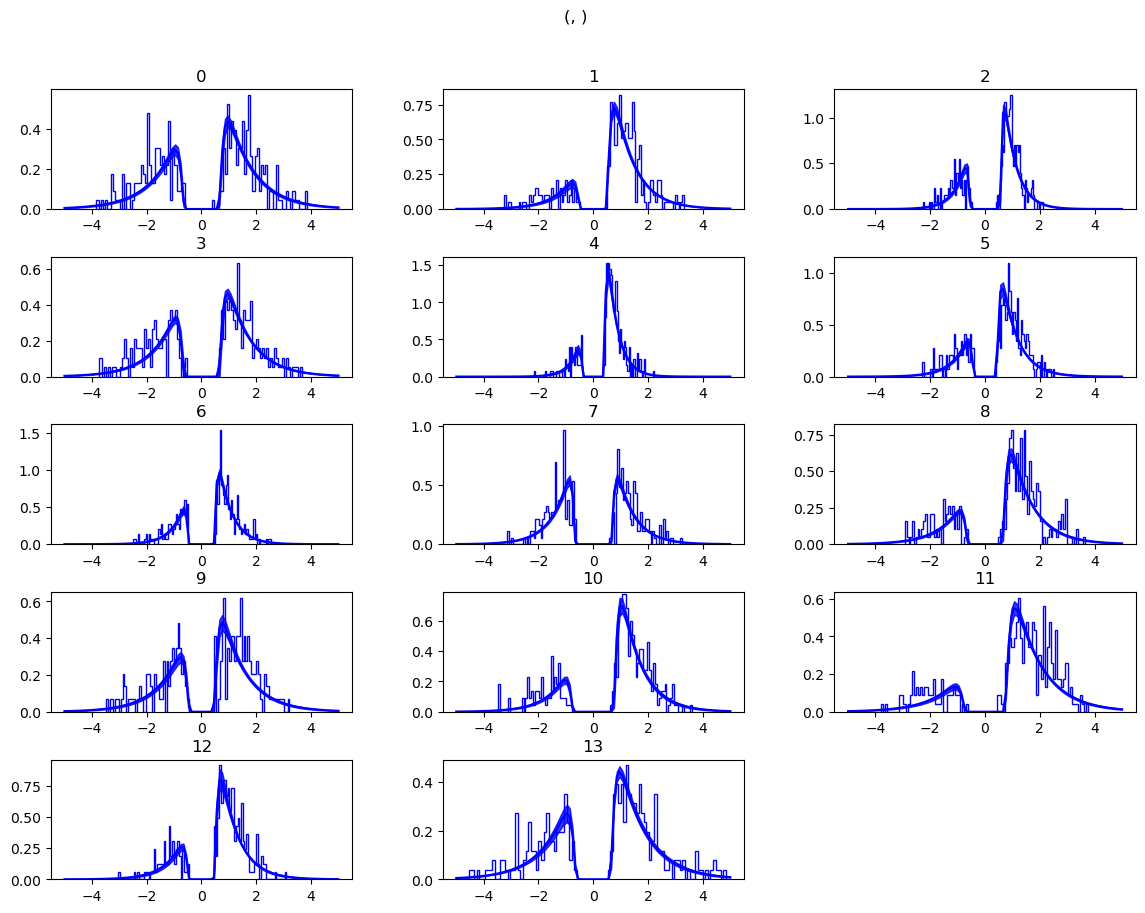

In [11]:
m1.plot_posterior_predictive(figsize=(14, 10))

## Calculate Gelman_rubin r hat.

The original tutorial used `for` loop:

In [12]:
# models = []
# for i in range(5):
#     m = hddm.HDDM(data)
#     m.find_starting_values()
#     m.sample(5000, burn=20)
#     models.append(m)

# hddm.analyze.gelman_rubin(models)

Here, we replace the `for` loop with parallel processing:

In [13]:
# parallel processing related packages
from p_tqdm import p_map
from functools import partial

In [14]:
def ms1(id, data=None, samples=None, burn=None, save_name="cavanagh2011_m1"): 

    print('running model%i'%id);
    
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [15]:
samples = 5000  # Cavanagh used 30,000 and 10, 000 burn.
burn = 1000    
thin = 1
chains = 4

In [16]:
models_1 = p_map(partial(ms1, data=data, samples=samples, burn=burn),
                 range(chains)) # progess bar is a mess ;(

running model0
running model1


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:


running model2

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])


running model3


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 -                 4%                  ] 210 of 5000 complete in 5.6 sec [                  0%                  ] 21 of 5000 complete in 0.5 sec[                  0%                  ] 21 of 5000 complete in 0.5 sec[                  0%                  ] 20 of 5000 complete in 0.5 sec [                  0%                  ] 41 of 5000 complete in 1.0 sec[                  0%                  ] 40 of 5000 complete in 1.0 sec[                  0%                  ] 40 of 5000 complete in 1.0 sec[                  1%                  ] 59 of 5000 complete in 1.5 sec[                  1%                  ] 60 of 5000 complete in 1.5 sec[                  1%                  ] 59 of 5000 complete in 1.5 sec[                  1%                  ] 59 of 5000 complete in 1.5 sec[                  1%                  ] 79 of 5000 complete in 2.0 sec[                  1%                  ] 80 of 5000 complete in 2.1 sec[                  1%                  ] 79 of 5000 complete in 2.0 sec[  

 -------          20%                  ] 1002 of 5000 complete in 27.2 sec [----             11%                  ] 571 of 5000 complete in 15.4 sec[----             11%                  ] 572 of 5000 complete in 15.5 sec[----             11%                  ] 587 of 5000 complete in 15.8 sec[----             11%                  ] 591 of 5000 complete in 15.9 sec[----             11%                  ] 588 of 5000 complete in 15.9 sec[----             11%                  ] 591 of 5000 complete in 16.0 sec[----             12%                  ] 607 of 5000 complete in 16.4 sec  [----             12%                  ] 607 of 5000 complete in 16.4 sec[----             12%                  ] 611 of 5000 complete in 16.5 sec[----             12%                  ] 611 of 5000 complete in 16.5 sec[----             12%                  ] 627 of 5000 complete in 16.9 sec[----             12%                  ] 631 of 5000 complete in 17.0 sec[----             12%                  ] 627 of

 -----------      30%                  ] 1512 of 5000 complete in 40.6 secc[--------         22%                  ] 1108 of 5000 complete in 29.8 sec[--------         22%                  ] 1117 of 5000 complete in 30.2 sec[--------         22%                  ] 1118 of 5000 complete in 30.3 sec[--------         22%                  ] 1123 of 5000 complete in 30.3 sec[--------         22%                  ] 1128 of 5000 complete in 30.3 sec[--------         22%                  ] 1136 of 5000 complete in 30.7 sec[--------         22%                  ] 1138 of 5000 complete in 30.8 sec[--------         22%                  ] 1142 of 5000 complete in 30.9 sec[--------         22%                  ] 1147 of 5000 complete in 30.8 sec[--------         23%                  ] 1155 of 5000 complete in 31.3 sec  [--------         23%                  ] 1157 of 5000 complete in 31.3 sec[--------         23%                  ] 1161 of 5000 complete in 31.4 sec[--------         23%              

[---------------- 44%                  ] 2200 of 5000 complete in 59.0 secc[------------     33%                  ] 1663 of 5000 complete in 44.6 sec[------------     33%                  ] 1661 of 5000 complete in 44.6 sec[------------     33%                  ] 1668 of 5000 complete in 44.6 sec[------------     33%                  ] 1668 of 5000 complete in 44.8 sec[------------     33%                  ] 1682 of 5000 complete in 45.1 sec[------------     33%                  ] 1680 of 5000 complete in 45.1 sec[------------     33%                  ] 1688 of 5000 complete in 45.1 sec[------------     33%                  ] 1688 of 5000 complete in 45.3 sec[------------     34%                  ] 1702 of 5000 complete in 45.7 sec[------------     34%                  ] 1700 of 5000 complete in 45.6 sec[------------     34%                  ] 1707 of 5000 complete in 45.6 sec[------------     34%                  ] 1707 of 5000 complete in 45.8 sec[-------------    34%                

 -----------------52%                  ] 2628 of 5000 complete in 70.4 secc[---------------- 44%                  ] 2209 of 5000 complete in 59.1 sec[---------------- 44%                  ] 2217 of 5000 complete in 59.5 sec[---------------- 44%                  ] 2223 of 5000 complete in 59.6 sec[---------------- 44%                  ] 2228 of 5000 complete in 59.5 sec[---------------- 44%                  ] 2228 of 5000 complete in 59.6 sec[---------------- 44%                  ] 2236 of 5000 complete in 60.0 sec[-----------------44%                  ] 2242 of 5000 complete in 60.1 sec[-----------------44%                  ] 2247 of 5000 complete in 60.0 sec[-----------------44%                  ] 2248 of 5000 complete in 60.2 sec[-----------------45%                  ] 2256 of 5000 complete in 60.5 sec[-----------------45%                  ] 2261 of 5000 complete in 60.6 sec[-----------------45%                  ] 2266 of 5000 complete in 60.5 sec[-----------------45%                

 -----------------65%----              ] 3284 of 5000 complete in 87.8 secc[-----------------55%                  ] 2754 of 5000 complete in 73.9 sec[-----------------55%                  ] 2754 of 5000 complete in 73.9 sec  [-----------------55%                  ] 2760 of 5000 complete in 73.9 sec[-----------------55%-                 ] 2765 of 5000 complete in 74.0 sec [-----------------55%-                 ] 2774 of 5000 complete in 74.4 sec[-----------------55%-                 ] 2784 of 5000 complete in 74.5 sec[-----------------55%-                 ] 2780 of 5000 complete in 74.5 sec[-----------------55%-                 ] 2792 of 5000 complete in 74.9 sec[-----------------55%-                 ] 2794 of 5000 complete in 74.9 sec[-----------------56%-                 ] 2803 of 5000 complete in 75.0 sec[-----------------56%-                 ] 2800 of 5000 complete in 75.0 sec[-----------------56%-                 ] 2811 of 5000 complete in 75.4 sec[-----------------56%-            

 -----------------70%------            ] 3515 of 5000 complete in 94.0 secc[-----------------66%-----             ] 3324 of 5000 complete in 88.8 sec[-----------------66%-----             ] 3321 of 5000 complete in 88.8 sec[-----------------66%-----             ] 3320 of 5000 complete in 88.9 sec[-----------------66%-----             ] 3322 of 5000 complete in 88.8 sec[-----------------66%-----             ] 3343 of 5000 complete in 89.4 sec[-----------------66%-----             ] 3340 of 5000 complete in 89.3 sec[-----------------66%-----             ] 3339 of 5000 complete in 89.4 sec[-----------------66%-----             ] 3341 of 5000 complete in 89.3 sec [-----------------67%-----             ] 3362 of 5000 complete in 89.9 sec [-----------------67%-----             ] 3359 of 5000 complete in 89.8 sec[-----------------67%-----             ] 3359 of 5000 complete in 89.9 sec[-----------------67%-----             ] 3360 of 5000 complete in 89.8 sec[-----------------67%-----         

 -----------------77%---------         ] 3882 of 5000 complete in 103.7 secc  [-----------------77%---------         ] 3863 of 5000 complete in 103.2 sec[-----------------77%---------         ] 3862 of 5000 complete in 103.2 sec[-----------------77%---------         ] 3863 of 5000 complete in 103.2 sec[-----------------77%---------         ] 3867 of 5000 complete in 103.2 sec [-----------------77%---------         ] 3883 of 5000 complete in 103.7 sec[-----------------77%---------         ] 3882 of 5000 complete in 103.7 sec[-----------------77%---------         ] 3887 of 5000 complete in 103.8 sec  [-----------------78%---------         ] 3902 of 5000 complete in 104.2 sec[-----------------78%---------         ] 3902 of 5000 complete in 104.2 sec[-----------------78%---------         ] 3902 of 5000 complete in 104.2 sec[-----------------78%---------         ] 3907 of 5000 complete in 104.3 sec [-----------------78%---------         ] 3922 of 5000 complete in 104.7 sec [----------------

 -----------------94%---------------   ] 4724 of 5000 complete in 125.8 secc[-----------------87%-------------     ] 4392 of 5000 complete in 117.1 sec[-----------------88%-------------     ] 4404 of 5000 complete in 117.5 sec[-----------------88%-------------     ] 4410 of 5000 complete in 117.6 sec[-----------------88%-------------     ] 4410 of 5000 complete in 117.6 sec[-----------------88%-------------     ] 4410 of 5000 complete in 117.7 sec[-----------------88%-------------     ] 4423 of 5000 complete in 118.0 sec[-----------------88%-------------     ] 4429 of 5000 complete in 118.1 sec[-----------------88%-------------     ] 4429 of 5000 complete in 118.1 sec[-----------------88%-------------     ] 4430 of 5000 complete in 118.2 sec[-----------------88%-------------     ] 4442 of 5000 complete in 118.5 sec[-----------------88%-------------     ] 4449 of 5000 complete in 118.6 sec[-----------------88%-------------     ] 4448 of 5000 complete in 118.6 sec[-----------------89%---

 [-----------------98%----------------- ] 4935 of 5000 complete in 131.4 sec[-----------------98%----------------- ] 4935 of 5000 complete in 131.5 sec[-----------------99%----------------- ] 4950 of 5000 complete in 131.9 sec[-----------------99%----------------- ] 4954 of 5000 complete in 131.9 sec[-----------------99%----------------- ] 4957 of 5000 complete in 132.0 sec[-----------------99%----------------- ] 4954 of 5000 complete in 132.0 sec[-----------------99%----------------- ] 4970 of 5000 complete in 132.4 sec[-----------------99%----------------- ] 4973 of 5000 complete in 132.4 sec[-----------------99%----------------- ] 4977 of 5000 complete in 132.5 sec[-----------------99%----------------- ] 4973 of 5000 complete in 132.5 sec[-----------------99%----------------- ] 4989 of 5000 complete in 132.9 sec[-----------------99%----------------- ] 4991 of 5000 complete in 132.9 sec[-----------------99%----------------- ] 4996 of 5000 complete in 133.0 sec[-----------------99%---

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

In [17]:
hddm.analyze.gelman_rubin(models_1)

{'a': 1.00015045085352,
 'a_std': 1.0001637951675955,
 'a_subj.0': 1.000389725844177,
 'a_subj.1': 1.000266354456909,
 'a_subj.2': 1.000253668119653,
 'a_subj.3': 1.0002029252759748,
 'a_subj.4': 0.9999242835140043,
 'a_subj.5': 1.0003353213982094,
 'a_subj.6': 0.999899296214968,
 'a_subj.7': 1.0002265065388474,
 'a_subj.8': 0.999979092797768,
 'a_subj.9': 1.000062244611272,
 'a_subj.10': 1.0007001534500513,
 'a_subj.11': 1.0000946380369449,
 'a_subj.12': 1.0000405464053908,
 'a_subj.13': 1.001289533629463,
 'v': 1.0000740656444331,
 'v_std': 1.0000138519954334,
 'v_subj.0': 1.0000773941710828,
 'v_subj.1': 0.9998977143335598,
 'v_subj.2': 1.0001145210512432,
 'v_subj.3': 1.0002196669844416,
 'v_subj.4': 1.0001512782893265,
 'v_subj.5': 1.0000129890097325,
 'v_subj.6': 0.9998828588485684,
 'v_subj.7': 0.999968058143524,
 'v_subj.8': 1.0000694415667783,
 'v_subj.9': 0.9999639688565432,
 'v_subj.10': 1.0000591662875362,
 'v_subj.11': 1.000017465446813,
 'v_subj.12': 1.0001560695278218,
 

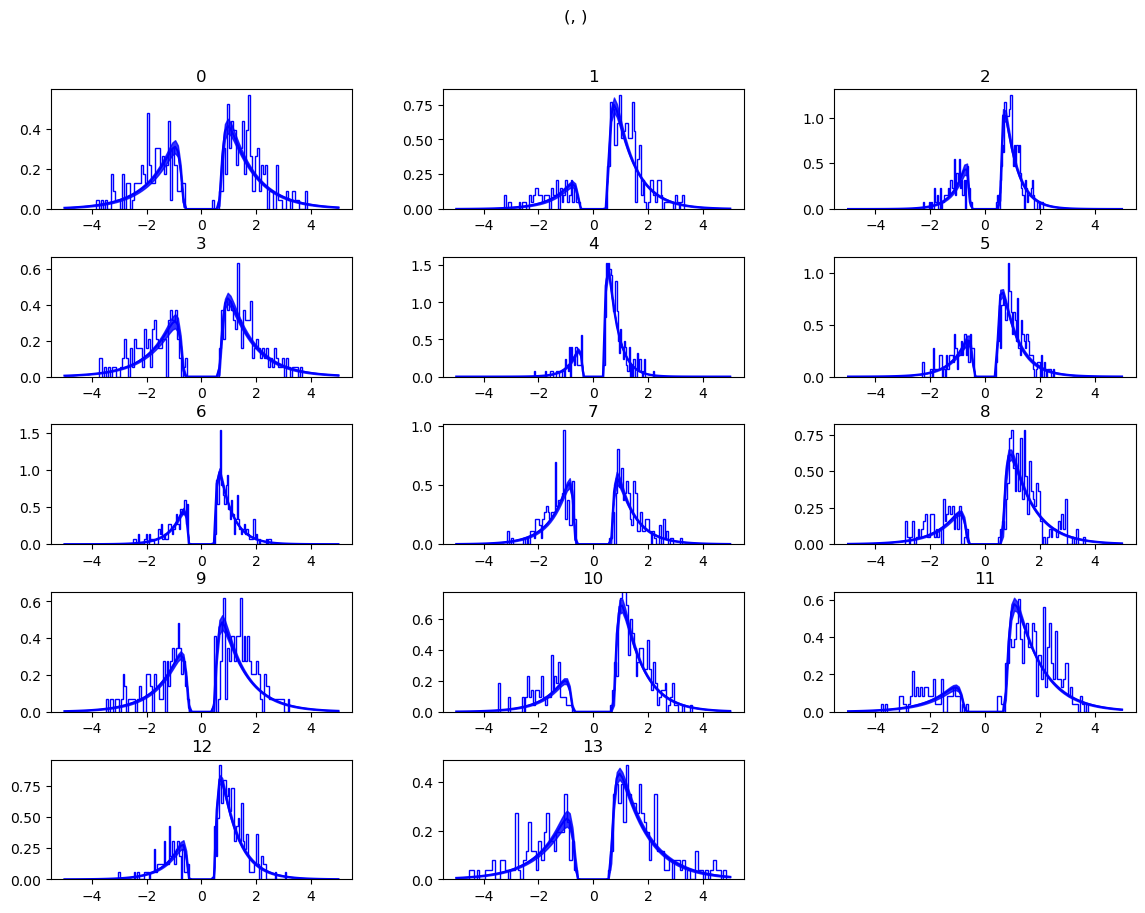

In [18]:
models_1[0].plot_posterior_predictive(figsize=(14, 10))

In [19]:
m_comb = kabuki.utils.concat_models(models_1) # combine four chains together

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

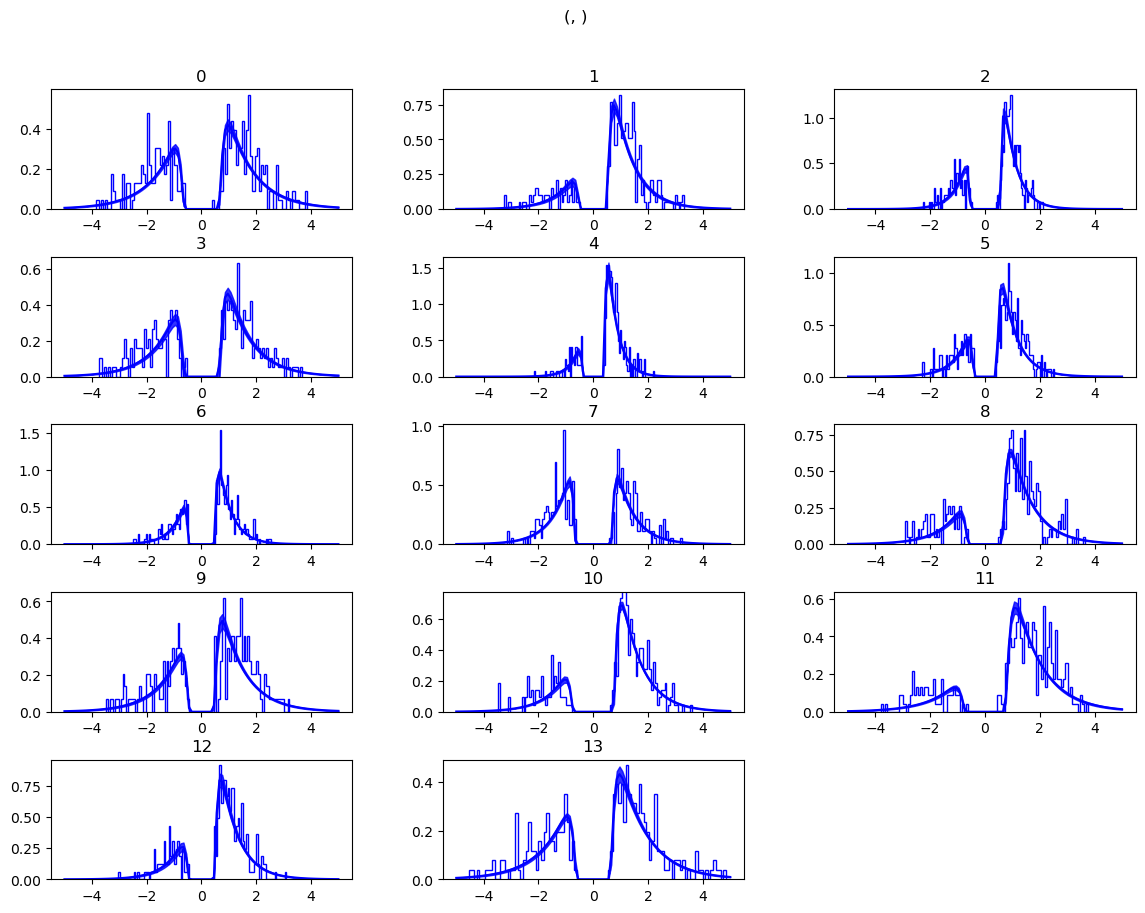

In [20]:
m_comb.plot_posterior_predictive(figsize=(14, 10))

### Model 2: `v` depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)
```

Here we defined a function for stimulus coding and used parallel processing

In [21]:
def ms2(id, data=None, samples=None, burn=None, save_name="cavanagh2011_m2"): 

    print('running model%i'%id);
    
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # save the model data
    m.save(mname)
    
    return m

In [22]:
# note: the samples, burn, and chains can be changed too
models_2 = p_map(partial(ms2, data=data, samples=samples, burn=burn),
                 range(chains))

  0%|          | 0/4 [00:00<?, ?it/s]

running model0
running model1

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:



running model2


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])


running model3

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarch

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 --                5%                  ] 281 of 5000 complete in 14.9 sec                  0%                  ] 11 of 5000 complete in 0.5 sec[                  0%                  ] 11 of 5000 complete in 0.5 sec[                  0%                  ] 11 of 5000 complete in 0.5 sec[                  0%                  ] 21 of 5000 complete in 1.1 sec[                  0%                  ] 21 of 5000 complete in 1.0 sec[                  0%                  ] 21 of 5000 complete in 1.0 sec[                  0%                  ] 21 of 5000 complete in 1.1 sec[                  0%                  ] 31 of 5000 complete in 1.6 sec[                  0%                  ] 31 of 5000 complete in 1.6 sec[                  0%                  ] 31 of 5000 complete in 1.6 sec[                  0%                  ] 31 of 5000 complete in 1.6 sec[                  0%                  ] 41 of 5000 complete in 2.1 sec[                  0%                  ] 41 of 5000 complete in 2.1 sec  [  

[----             11%                  ] 587 of 5000 complete in 31.1 secc [--                5%                  ] 299 of 5000 complete in 15.9 sec[--                6%                  ] 308 of 5000 complete in 16.2 sec[--                6%                  ] 308 of 5000 complete in 16.4 sec[--                6%                  ] 309 of 5000 complete in 16.4 sec[--                6%                  ] 311 of 5000 complete in 16.5 sec[--                6%                  ] 317 of 5000 complete in 16.7 sec[--                6%                  ] 318 of 5000 complete in 16.9 sec[--                6%                  ] 320 of 5000 complete in 17.0 sec[--                6%                  ] 319 of 5000 complete in 16.9 sec[--                6%                  ] 327 of 5000 complete in 17.3 sec[--                6%                  ] 328 of 5000 complete in 17.4 sec[--                6%                  ] 330 of 5000 complete in 17.5 sec[--                6%                  ] 329 of 5

 -----            14%                  ] 726 of 5000 complete in 38.5 secc[----             11%                  ] 594 of 5000 complete in 31.4 sec[----             11%                  ] 597 of 5000 complete in 31.7 sec[----             11%                  ] 598 of 5000 complete in 31.7 sec[----             11%                  ] 599 of 5000 complete in 31.8 sec[----             12%                  ] 604 of 5000 complete in 32.0 sec[----             12%                  ] 607 of 5000 complete in 32.2 sec[----             12%                  ] 608 of 5000 complete in 32.2 sec[----             12%                  ] 609 of 5000 complete in 32.4 sec[----             12%                  ] 614 of 5000 complete in 32.5 sec[----             12%                  ] 617 of 5000 complete in 32.7 sec[----             12%                  ] 618 of 5000 complete in 32.7 sec[----             12%                  ] 619 of 5000 complete in 32.9 sec[----             12%                  ] 624 of 50

 -------          20%                  ] 1003 of 5000 complete in 53.4 sec[------           17%                  ] 878 of 5000 complete in 46.7 sec  [------           17%                  ] 885 of 5000 complete in 47.0 sec[------           17%                  ] 884 of 5000 complete in 47.0 sec[------           17%                  ] 885 of 5000 complete in 47.1 sec[------           17%                  ] 888 of 5000 complete in 47.2 sec[------           17%                  ] 894 of 5000 complete in 47.6 sec [------           17%                  ] 895 of 5000 complete in 47.7 sec[------           17%                  ] 898 of 5000 complete in 47.8 sec[------           18%                  ] 904 of 5000 complete in 48.1 sec[------           18%                  ] 905 of 5000 complete in 48.1 sec[------           18%                  ] 905 of 5000 complete in 48.2 sec[------           18%                  ] 908 of 5000 complete in 48.3 sec[------           18%                  ] 914 of

 ----------       27%                  ] 1369 of 5000 complete in 72.9 secc[--------         23%                  ] 1173 of 5000 complete in 62.3 sec[--------         23%                  ] 1172 of 5000 complete in 62.3 sec[--------         23%                  ] 1173 of 5000 complete in 62.4 sec[--------         23%                  ] 1177 of 5000 complete in 62.6 sec[--------         23%                  ] 1183 of 5000 complete in 62.8 sec[--------         23%                  ] 1182 of 5000 complete in 62.9 sec[--------         23%                  ] 1183 of 5000 complete in 63.0 sec[---------        23%                  ] 1187 of 5000 complete in 63.1 sec[---------        23%                  ] 1193 of 5000 complete in 63.4 sec[---------        23%                  ] 1192 of 5000 complete in 63.4 sec[---------        23%                  ] 1193 of 5000 complete in 63.5 sec[---------        23%                  ] 1197 of 5000 complete in 63.7 sec[---------        24%                

 ------------     34%                  ] 1705 of 5000 complete in 90.8 secc[-----------      28%                  ] 1448 of 5000 complete in 77.0 sec[----------       28%                  ] 1444 of 5000 complete in 77.1 sec[-----------      29%                  ] 1450 of 5000 complete in 77.3 sec[-----------      29%                  ] 1453 of 5000 complete in 77.4 sec[-----------      29%                  ] 1458 of 5000 complete in 77.5 sec[-----------      29%                  ] 1454 of 5000 complete in 77.6 sec[-----------      29%                  ] 1460 of 5000 complete in 77.9 sec[-----------      29%                  ] 1463 of 5000 complete in 78.0 sec[-----------      29%                  ] 1467 of 5000 complete in 78.1 sec[-----------      29%                  ] 1464 of 5000 complete in 78.1 sec[-----------      29%                  ] 1469 of 5000 complete in 78.4 sec[-----------      29%                  ] 1473 of 5000 complete in 78.5 sec[-----------      29%                

 [-------------    34%                  ] 1721 of 5000 complete in 91.7 sec[-------------    34%                  ] 1725 of 5000 complete in 91.8 sec[-------------    34%                  ] 1720 of 5000 complete in 91.8 sec[-------------    34%                  ] 1727 of 5000 complete in 92.1 sec[-------------    34%                  ] 1731 of 5000 complete in 92.2 sec[-------------    34%                  ] 1735 of 5000 complete in 92.3 sec[-------------    34%                  ] 1730 of 5000 complete in 92.4 sec[-------------    34%                  ] 1737 of 5000 complete in 92.7 sec[-------------    34%                  ] 1741 of 5000 complete in 92.7 sec[-------------    34%                  ] 1745 of 5000 complete in 92.9 sec[-------------    34%                  ] 1740 of 5000 complete in 92.9 sec[-------------    34%                  ] 1747 of 5000 complete in 93.2 sec[-------------    35%                  ] 1751 of 5000 complete in 93.3 sec[-------------    35%                

 [---------------  39%                  ] 1996 of 5000 complete in 106.4 sec[---------------  39%                  ] 1998 of 5000 complete in 106.4 sec[---------------  40%                  ] 2000 of 5000 complete in 106.4 sec[---------------  39%                  ] 1998 of 5000 complete in 106.6 sec[---------------  40%                  ] 2006 of 5000 complete in 106.9 sec[---------------  40%                  ] 2008 of 5000 complete in 106.9 sec[---------------  40%                  ] 2010 of 5000 complete in 107.0 sec[---------------  40%                  ] 2008 of 5000 complete in 107.1 sec[---------------  40%                  ] 2016 of 5000 complete in 107.4 sec[---------------  40%                  ] 2018 of 5000 complete in 107.4 sec[---------------  40%                  ] 2019 of 5000 complete in 107.5 sec[---------------  40%                  ] 2018 of 5000 complete in 107.6 sec[---------------  40%                  ] 2026 of 5000 complete in 107.9 sec[---------------  40%   

 [-----------------45%                  ] 2266 of 5000 complete in 120.6 sec[-----------------45%                  ] 2266 of 5000 complete in 120.9 sec[-----------------45%                  ] 2274 of 5000 complete in 121.1 sec[-----------------45%                  ] 2274 of 5000 complete in 121.1 sec[-----------------45%                  ] 2276 of 5000 complete in 121.2 sec[-----------------45%                  ] 2276 of 5000 complete in 121.4 sec[-----------------45%                  ] 2284 of 5000 complete in 121.6 sec[-----------------45%                  ] 2284 of 5000 complete in 121.6 sec[-----------------45%                  ] 2286 of 5000 complete in 121.7 sec[-----------------45%                  ] 2286 of 5000 complete in 121.9 sec[-----------------45%                  ] 2294 of 5000 complete in 122.1 sec[-----------------45%                  ] 2294 of 5000 complete in 122.1 sec[-----------------45%                  ] 2296 of 5000 complete in 122.2 sec[-----------------45%   

 [-----------------50%                  ] 2544 of 5000 complete in 135.3 sec[-----------------50%                  ] 2544 of 5000 complete in 135.3 sec[-----------------50%                  ] 2546 of 5000 complete in 135.5 sec[-----------------50%                  ] 2544 of 5000 complete in 135.6 sec[-----------------51%                  ] 2554 of 5000 complete in 135.9 sec[-----------------51%                  ] 2554 of 5000 complete in 135.9 sec[-----------------51%                  ] 2556 of 5000 complete in 136.0 sec[-----------------51%                  ] 2553 of 5000 complete in 136.1 sec[-----------------51%                  ] 2564 of 5000 complete in 136.4 sec[-----------------51%                  ] 2564 of 5000 complete in 136.4 sec[-----------------51%                  ] 2566 of 5000 complete in 136.5 sec[-----------------51%                  ] 2563 of 5000 complete in 136.6 sec[-----------------51%                  ] 2574 of 5000 complete in 136.9 sec[-----------------51%   

 -----------------60%--                ] 3011 of 5000 complete in 160.2 secc[-----------------56%-                 ] 2814 of 5000 complete in 149.9 sec[-----------------56%-                 ] 2822 of 5000 complete in 150.0 sec[-----------------56%-                 ] 2823 of 5000 complete in 150.2 sec[-----------------56%-                 ] 2823 of 5000 complete in 150.1 sec[-----------------56%-                 ] 2824 of 5000 complete in 150.4 sec[-----------------56%-                 ] 2832 of 5000 complete in 150.6 sec[-----------------56%-                 ] 2833 of 5000 complete in 150.7 sec[-----------------56%-                 ] 2833 of 5000 complete in 150.7 sec[-----------------56%-                 ] 2834 of 5000 complete in 151.0 sec[-----------------56%-                 ] 2842 of 5000 complete in 151.1 sec[-----------------56%-                 ] 2843 of 5000 complete in 151.2 sec[-----------------56%-                 ] 2843 of 5000 complete in 151.2 sec[-----------------56%-  

 -----------------66%-----             ] 3309 of 5000 complete in 175.9 secc [-----------------62%---               ] 3100 of 5000 complete in 164.9 sec[-----------------62%---               ] 3101 of 5000 complete in 164.9 sec[-----------------62%---               ] 3103 of 5000 complete in 165.2 sec[-----------------62%---               ] 3112 of 5000 complete in 165.5 sec[-----------------62%---               ] 3110 of 5000 complete in 165.4 sec[-----------------62%---               ] 3111 of 5000 complete in 165.4 sec[-----------------62%---               ] 3113 of 5000 complete in 165.7 sec [-----------------62%---               ] 3122 of 5000 complete in 166.0 sec[-----------------62%---               ] 3121 of 5000 complete in 166.0 sec[-----------------62%---               ] 3123 of 5000 complete in 166.3 sec[-----------------62%---               ] 3130 of 5000 complete in 166.5 sec[-----------------62%---               ] 3129 of 5000 complete in 166.5 sec[-----------------62%-

 -----------------72%-------           ] 3606 of 5000 complete in 191.7 secc[-----------------67%-----             ] 3380 of 5000 complete in 179.8 sec[-----------------67%-----             ] 3387 of 5000 complete in 180.0 sec[-----------------67%-----             ] 3380 of 5000 complete in 180.0 sec[-----------------67%-----             ] 3389 of 5000 complete in 180.2 sec[-----------------67%-----             ] 3390 of 5000 complete in 180.3 sec[-----------------67%-----             ] 3397 of 5000 complete in 180.6 sec[-----------------67%-----             ] 3390 of 5000 complete in 180.5 sec[-----------------67%-----             ] 3399 of 5000 complete in 180.7 sec[-----------------68%-----             ] 3400 of 5000 complete in 180.8 sec[-----------------68%-----             ] 3407 of 5000 complete in 181.1 sec[-----------------68%-----             ] 3400 of 5000 complete in 181.0 sec[-----------------68%-----             ] 3409 of 5000 complete in 181.3 sec[-----------------68%---

 -----------------73%-------           ] 3675 of 5000 complete in 195.6 secc [-----------------73%-------           ] 3654 of 5000 complete in 194.5 sec[-----------------73%-------           ] 3663 of 5000 complete in 194.9 sec[-----------------73%-------           ] 3656 of 5000 complete in 194.8 sec[-----------------73%-------           ] 3665 of 5000 complete in 195.0 sec[-----------------73%-------           ] 3663 of 5000 complete in 195.0 sec[-----------------73%-------           ] 3673 of 5000 complete in 195.4 sec[-----------------73%-------           ] 3666 of 5000 complete in 195.3 sec [-----------------73%-------           ] 3673 of 5000 complete in 195.6 sec[-----------------73%-------           ] 3683 of 5000 complete in 195.9 sec[-----------------73%-------           ] 3676 of 5000 complete in 195.9 sec[-----------------73%--------          ] 3685 of 5000 complete in 196.1 sec[-----------------73%-------           ] 3683 of 5000 complete in 196.1 sec[-----------------73%-

 [-----------------78%---------         ] 3932 of 5000 complete in 209.2 sec[-----------------78%---------         ] 3924 of 5000 complete in 209.2 sec[-----------------78%---------         ] 3931 of 5000 complete in 209.2 sec[-----------------78%---------         ] 3940 of 5000 complete in 209.6 sec[-----------------78%---------         ] 3942 of 5000 complete in 209.7 sec[-----------------78%---------         ] 3934 of 5000 complete in 209.7 sec[-----------------78%---------         ] 3941 of 5000 complete in 209.8 sec[-----------------79%----------        ] 3950 of 5000 complete in 210.2 sec[-----------------79%----------        ] 3951 of 5000 complete in 210.2 sec[-----------------78%---------         ] 3944 of 5000 complete in 210.3 sec[-----------------79%----------        ] 3951 of 5000 complete in 210.3 sec[-----------------79%----------        ] 3960 of 5000 complete in 210.7 sec[-----------------79%----------        ] 3961 of 5000 complete in 210.7 sec[-----------------79%---

 -----------------87%-------------     ] 4381 of 5000 complete in 232.9 secc[-----------------84%-----------       ] 4209 of 5000 complete in 223.9 sec[-----------------84%------------      ] 4211 of 5000 complete in 223.9 sec[-----------------84%-----------       ] 4208 of 5000 complete in 223.9 sec[-----------------84%-----------       ] 4203 of 5000 complete in 224.0 sec[-----------------84%------------      ] 4219 of 5000 complete in 224.4 sec[-----------------84%------------      ] 4221 of 5000 complete in 224.4 sec[-----------------84%------------      ] 4218 of 5000 complete in 224.5 sec[-----------------84%------------      ] 4213 of 5000 complete in 224.5 sec[-----------------84%------------      ] 4229 of 5000 complete in 224.9 sec[-----------------84%------------      ] 4231 of 5000 complete in 225.0 sec[-----------------84%------------      ] 4228 of 5000 complete in 225.0 sec[-----------------84%------------      ] 4223 of 5000 complete in 225.0 sec[-----------------84%---

 -----------------94%---------------   ] 4705 of 5000 complete in 250.4 secc[-----------------89%-------------     ] 4470 of 5000 complete in 238.3 sec[-----------------89%--------------    ] 4484 of 5000 complete in 238.7 sec[-----------------89%--------------    ] 4486 of 5000 complete in 238.7 sec[-----------------89%--------------    ] 4483 of 5000 complete in 238.8 sec[-----------------89%--------------    ] 4480 of 5000 complete in 238.8 sec[-----------------89%--------------    ] 4494 of 5000 complete in 239.2 sec[-----------------89%--------------    ] 4496 of 5000 complete in 239.3 sec[-----------------89%--------------    ] 4492 of 5000 complete in 239.3 sec[-----------------89%--------------    ] 4490 of 5000 complete in 239.4 sec[-----------------90%--------------    ] 4504 of 5000 complete in 239.7 sec[-----------------90%--------------    ] 4506 of 5000 complete in 239.8 sec[-----------------90%--------------    ] 4502 of 5000 complete in 239.8 sec[-----------------90%---

 -----------------99%----------------- ] 4981 of 5000 complete in 265.2 secec[-----------------95%----------------  ] 4755 of 5000 complete in 253.0 sec[-----------------94%----------------  ] 4749 of 5000 complete in 253.1 sec[-----------------95%----------------  ] 4764 of 5000 complete in 253.5 sec[-----------------95%----------------  ] 4765 of 5000 complete in 253.5 sec[-----------------95%----------------  ] 4760 of 5000 complete in 253.5 sec[-----------------95%----------------  ] 4759 of 5000 complete in 253.6 sec[-----------------95%----------------  ] 4774 of 5000 complete in 254.0 sec[-----------------95%----------------  ] 4774 of 5000 complete in 254.0 sec[-----------------95%----------------  ] 4770 of 5000 complete in 254.1 sec[-----------------95%----------------  ] 4769 of 5000 complete in 254.1 sec[-----------------95%----------------  ] 4784 of 5000 complete in 254.5 sec[-----------------95%----------------  ] 4784 of 5000 complete in 254.6 sec[-----------------95%--

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

 [-----------------100%-----------------] 5000 of 5000 complete in 266.5 sec

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

In [23]:
m_stim_all = kabuki.utils.concat_models(models_2) 

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

Text(0.5, 1.0, 'Posterior of drift-rate group means')

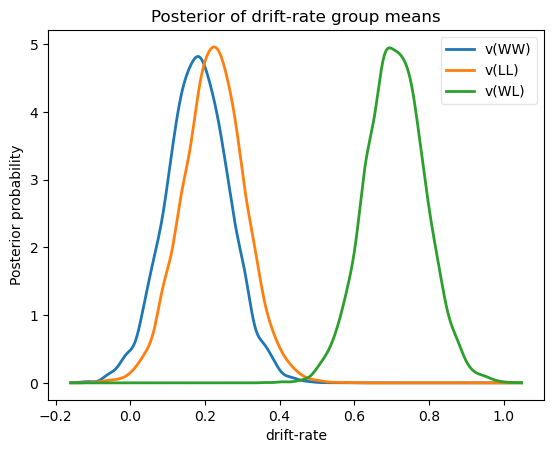

In [24]:
v_WW, v_LL, v_WL = m_stim_all.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
# plt.savefig('hddm_demo_fig_06.pdf')

In [25]:
print("P(WW > LL) = ", (v_WW.trace() > v_LL.trace()).mean())
print("P(LL > WL) = ", (v_LL.trace() > v_WL.trace()).mean())

P(WW > LL) =  0.35825
P(LL > WL) =  0.0


In [26]:
print("Lumped model DIC: %f" % m1.dic)
print("Stimulus model DIC: %f" % m_stim_all.dic)

Lumped model DIC: 10974.011716
Stimulus model DIC: 10786.570410


## Within-subject effects

In [27]:
from patsy import dmatrix
dmatrix("C(stim, Treatment('WL'))", data.head(10))

DesignMatrix with shape (10, 3)
  Intercept  C(stim, Treatment('WL'))[T.LL]  C(stim, Treatment('WL'))[T.WW]
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
  Terms:
    'Intercept' (column 0)
    "C(stim, Treatment('WL'))" (columns 1:3)

The original code in the tutorial was:

```
m_within_subj = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))")
m_within_subj.sample(5000, burn=200)
```

Here we used four chains for parallel processing

In [28]:
def run_m_reg(id, data=None, samples=None, burn=None, save_name="cavanagh2011_reg"): 
    
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
    m = hddm.HDDMRegressor(data,
                           "v ~ C(stim, Treatment('WL'))")
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [29]:
m_reg_list = p_map(partial(run_m_reg, data=data, samples=5000, burn=1000),
                   range(chains))

  0%|          | 0/4 [00:00<?, ?it/s]

Adding these covariates:
['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]
Adding these covariates:
['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:



Adding these covariates:
['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])


Adding these covariates:


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])


['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [                  0%                  ] 2 of 5000 complete in 0.5 sec[                  0%                  ] 2 of 5000 complete in 0.5 sec[                  0%                  ] 2 of 5000 complete in 0.6 sec[                  0%                  ] 3 of 5000 complete in 0.8 sec[                  0%                  ] 4 of 5000 complete in 1.1 sec[                  0%                  ] 4 of 5000 complete in 1.0 sec[                  0%                  ] 4 of 5000 complete in 1.2 sec[                  0%                  ] 5 of 5000 complete in 1.3 sec[                  0%                  ] 7 of 5000 complete in 1.7 sec[                  0%                  ] 7 of 5000 complete in 1.7 sec[                  0%                  ] 7 of 5000 complete in 1.9 sec[                  0%                  ] 8 of 5000 complete in 2.0 sec[                  0%                  ] 10 of 5000 complete in 2.3 sec[                  0%                  ] 10 of 5000 complete in 2.3 sec[                

 -                 3%                  ] 163 of 5000 complete in 34.3 sec[                  1%                  ] 88 of 5000 complete in 18.4 sec[                  1%                  ] 85 of 5000 complete in 18.5 sec[                  1%                  ] 89 of 5000 complete in 18.9 sec[                  1%                  ] 91 of 5000 complete in 19.1 sec[                  1%                  ] 91 of 5000 complete in 19.1 sec[                  1%                  ] 88 of 5000 complete in 19.1 sec[                  1%                  ] 92 of 5000 complete in 19.6 sec[                  1%                  ] 94 of 5000 complete in 19.7 sec[                  1%                  ] 94 of 5000 complete in 19.7 sec[                  1%                  ] 91 of 5000 complete in 19.8 sec[                  1%                  ] 95 of 5000 complete in 20.2 sec[                  1%                  ] 97 of 5000 complete in 20.4 sec[                  1%                  ] 97 of 5000 complete in

 [-                 3%                  ] 173 of 5000 complete in 36.4 sec[-                 3%                  ] 175 of 5000 complete in 36.6 sec[-                 3%                  ] 175 of 5000 complete in 36.8 sec[-                 3%                  ] 172 of 5000 complete in 36.7 sec[-                 3%                  ] 176 of 5000 complete in 37.0 sec[-                 3%                  ] 178 of 5000 complete in 37.3 sec[-                 3%                  ] 178 of 5000 complete in 37.4 sec[-                 3%                  ] 175 of 5000 complete in 37.4 sec[-                 3%                  ] 179 of 5000 complete in 37.7 sec[-                 3%                  ] 181 of 5000 complete in 37.9 sec[-                 3%                  ] 181 of 5000 complete in 38.0 sec[-                 3%                  ] 178 of 5000 complete in 38.0 sec[-                 3%                  ] 182 of 5000 complete in 38.3 sec[-                 3%                  ] 184 of 50

 --                5%                  ] 293 of 5000 complete in 61.4 secc[-                 5%                  ] 258 of 5000 complete in 54.3 sec[-                 5%                  ] 256 of 5000 complete in 54.4 sec[-                 5%                  ] 260 of 5000 complete in 54.6 sec[-                 5%                  ] 261 of 5000 complete in 54.8 sec[-                 5%                  ] 261 of 5000 complete in 54.9 sec[-                 5%                  ] 259 of 5000 complete in 55.1 sec[-                 5%                  ] 263 of 5000 complete in 55.2 sec[--                5%                  ] 264 of 5000 complete in 55.5 sec[--                5%                  ] 264 of 5000 complete in 55.5 sec[-                 5%                  ] 262 of 5000 complete in 55.7 sec[--                5%                  ] 266 of 5000 complete in 55.8 sec[--                5%                  ] 267 of 5000 complete in 56.0 sec[--                5%                  ] 267 of 50

 ---               8%                  ] 409 of 5000 complete in 85.9 secc[--                6%                  ] 343 of 5000 complete in 72.2 sec[--                6%                  ] 344 of 5000 complete in 72.3 sec[--                6%                  ] 341 of 5000 complete in 72.4 sec[--                6%                  ] 345 of 5000 complete in 72.6 sec[--                6%                  ] 347 of 5000 complete in 72.9 sec[--                6%                  ] 346 of 5000 complete in 72.9 sec[--                6%                  ] 344 of 5000 complete in 73.0 sec[--                6%                  ] 348 of 5000 complete in 73.2 sec[--                7%                  ] 350 of 5000 complete in 73.5 sec[--                6%                  ] 349 of 5000 complete in 73.5 sec[--                6%                  ] 347 of 5000 complete in 73.6 sec[--                7%                  ] 351 of 5000 complete in 73.8 sec[--                7%                  ] 353 of 50

 ---               9%                  ] 488 of 5000 complete in 102.4 sec[---               8%                  ] 431 of 5000 complete in 90.2 sec[---               8%                  ] 430 of 5000 complete in 90.3 sec[---               8%                  ] 428 of 5000 complete in 90.3 sec[---               8%                  ] 432 of 5000 complete in 90.6 sec[---               8%                  ] 434 of 5000 complete in 90.9 sec[---               8%                  ] 433 of 5000 complete in 90.9 sec[---               8%                  ] 431 of 5000 complete in 90.9 sec[---               8%                  ] 435 of 5000 complete in 91.2 sec[---               8%                  ] 437 of 5000 complete in 91.5 sec[---               8%                  ] 436 of 5000 complete in 91.5 sec[---               8%                  ] 434 of 5000 complete in 91.5 sec[---               8%                  ] 438 of 5000 complete in 91.8 sec[---               8%                  ] 440 of 50

 ----             11%                  ] 588 of 5000 complete in 123.1 secc[---              10%                  ] 518 of 5000 complete in 108.6 sec[---              10%                  ] 515 of 5000 complete in 108.7 sec[---              10%                  ] 519 of 5000 complete in 108.8 sec[---              10%                  ] 517 of 5000 complete in 108.8 sec[---              10%                  ] 521 of 5000 complete in 109.3 sec[---              10%                  ] 518 of 5000 complete in 109.4 sec[---              10%                  ] 522 of 5000 complete in 109.4 sec[---              10%                  ] 520 of 5000 complete in 109.5 sec[---              10%                  ] 524 of 5000 complete in 110.0 sec  [---              10%                  ] 521 of 5000 complete in 110.0 sec[---              10%                  ] 525 of 5000 complete in 110.0 sec[---              10%                  ] 523 of 5000 complete in 110.1 sec[----             10%              

 [----             11%                  ] 599 of 5000 complete in 126.0 sec[----             12%                  ] 602 of 5000 complete in 126.2 sec[----             12%                  ] 603 of 5000 complete in 126.2 sec[----             12%                  ] 601 of 5000 complete in 126.4 sec[----             12%                  ] 602 of 5000 complete in 126.6 sec[----             12%                  ] 605 of 5000 complete in 126.8 sec[----             12%                  ] 606 of 5000 complete in 126.8 sec[----             12%                  ] 604 of 5000 complete in 126.9 sec[----             12%                  ] 605 of 5000 complete in 127.3 sec[----             12%                  ] 608 of 5000 complete in 127.5 sec[----             12%                  ] 609 of 5000 complete in 127.4 sec[----             12%                  ] 607 of 5000 complete in 127.6 sec[----             12%                  ] 608 of 5000 complete in 127.9 sec[----             12%                

 [-----            13%                  ] 681 of 5000 complete in 143.4 sec[-----            13%                  ] 682 of 5000 complete in 143.4 sec[-----            13%                  ] 686 of 5000 complete in 143.7 sec[-----            13%                  ] 687 of 5000 complete in 143.9 sec[-----            13%                  ] 684 of 5000 complete in 144.0 sec[-----            13%                  ] 685 of 5000 complete in 144.1 sec[-----            13%                  ] 689 of 5000 complete in 144.4 sec[-----            13%                  ] 690 of 5000 complete in 144.5 sec[-----            13%                  ] 687 of 5000 complete in 144.7 sec[-----            13%                  ] 688 of 5000 complete in 144.7 sec[-----            13%                  ] 692 of 5000 complete in 145.1 sec[-----            13%                  ] 693 of 5000 complete in 145.1 sec[-----            13%                  ] 690 of 5000 complete in 145.3 sec[-----            13%                

 ------           16%                  ] 804 of 5000 complete in 169.2 secc[-----            15%                  ] 765 of 5000 complete in 161.0 sec[-----            15%                  ] 766 of 5000 complete in 161.2 sec[-----            15%                  ] 770 of 5000 complete in 161.4 sec[-----            15%                  ] 771 of 5000 complete in 161.4 sec[-----            15%                  ] 768 of 5000 complete in 161.6 sec[-----            15%                  ] 769 of 5000 complete in 161.8 sec[-----            15%                  ] 773 of 5000 complete in 162.0 sec[-----            15%                  ] 774 of 5000 complete in 162.0 sec[-----            15%                  ] 771 of 5000 complete in 162.2 sec[-----            15%                  ] 772 of 5000 complete in 162.4 sec[-----            15%                  ] 776 of 5000 complete in 162.7 sec[-----            15%                  ] 777 of 5000 complete in 162.7 sec[-----            15%                

 [------           17%                  ] 851 of 5000 complete in 178.1 sec[------           17%                  ] 853 of 5000 complete in 178.7 sec[------           17%                  ] 850 of 5000 complete in 178.6 sec[------           16%                  ] 849 of 5000 complete in 178.7 sec[------           17%                  ] 854 of 5000 complete in 178.7 sec[------           17%                  ] 856 of 5000 complete in 179.3 sec[------           17%                  ] 853 of 5000 complete in 179.2 sec[------           17%                  ] 852 of 5000 complete in 179.3 sec[------           17%                  ] 857 of 5000 complete in 179.3 sec[------           17%                  ] 859 of 5000 complete in 179.9 sec[------           17%                  ] 856 of 5000 complete in 179.8 sec[------           17%                  ] 855 of 5000 complete in 179.9 sec[------           17%                  ] 860 of 5000 complete in 179.9 sec[------           17%                

 [-------          18%                  ] 935 of 5000 complete in 195.6 sec[-------          18%                  ] 930 of 5000 complete in 195.7 sec[-------          18%                  ] 934 of 5000 complete in 195.9 sec[-------          18%                  ] 937 of 5000 complete in 196.3 sec[-------          18%                  ] 938 of 5000 complete in 196.2 sec[-------          18%                  ] 933 of 5000 complete in 196.3 sec[-------          18%                  ] 937 of 5000 complete in 196.5 sec[-------          18%                  ] 940 of 5000 complete in 196.9 sec[-------          18%                  ] 941 of 5000 complete in 196.8 sec[-------          18%                  ] 936 of 5000 complete in 196.9 sec[-------          18%                  ] 940 of 5000 complete in 197.2 sec[-------          18%                  ] 939 of 5000 complete in 197.5 sec  [-------          18%                  ] 943 of 5000 complete in 197.5 sec[-------          18%              

[--------         21%                  ] 1098 of 5000 complete in 230.0 secc[-------          20%                  ] 1014 of 5000 complete in 213.0 sec[-------          20%                  ] 1019 of 5000 complete in 213.3 sec[-------          20%                  ] 1021 of 5000 complete in 213.5 sec[-------          20%                  ] 1018 of 5000 complete in 213.4 sec[-------          20%                  ] 1017 of 5000 complete in 213.6 sec[-------          20%                  ] 1022 of 5000 complete in 214.0 sec[-------          20%                  ] 1024 of 5000 complete in 214.1 sec[-------          20%                  ] 1021 of 5000 complete in 214.1 sec[-------          20%                  ] 1020 of 5000 complete in 214.2 sec  [-------          20%                  ] 1027 of 5000 complete in 214.7 sec[-------          20%                  ] 1025 of 5000 complete in 214.6 sec[-------          20%                  ] 1024 of 5000 complete in 214.8 sec[-------          20% 

 --------         23%                  ] 1173 of 5000 complete in 246.5 secc[--------         22%                  ] 1101 of 5000 complete in 230.3 sec[--------         22%                  ] 1101 of 5000 complete in 230.6 sec[--------         21%                  ] 1098 of 5000 complete in 230.7 sec[--------         22%                  ] 1100 of 5000 complete in 230.8 sec[--------         22%                  ] 1104 of 5000 complete in 230.9 sec[--------         22%                  ] 1101 of 5000 complete in 231.3 sec[--------         22%                  ] 1104 of 5000 complete in 231.3 sec[--------         22%                  ] 1103 of 5000 complete in 231.5 sec[--------         22%                  ] 1107 of 5000 complete in 231.6 sec[--------         22%                  ] 1104 of 5000 complete in 232.0 sec[--------         22%                  ] 1107 of 5000 complete in 232.0 sec[--------         22%                  ] 1106 of 5000 complete in 232.1 sec[--------         22%   

 ---------        23%                  ] 1188 of 5000 complete in 248.9 secc[---------        23%                  ] 1185 of 5000 complete in 248.1 sec[--------         23%                  ] 1184 of 5000 complete in 248.3 sec[--------         23%                  ] 1182 of 5000 complete in 248.4 sec[---------        23%                  ] 1185 of 5000 complete in 248.4 sec[---------        23%                  ] 1188 of 5000 complete in 248.7 sec [---------        23%                  ] 1185 of 5000 complete in 249.0 sec[---------        23%                  ] 1187 of 5000 complete in 249.0 sec[---------        23%                  ] 1191 of 5000 complete in 249.4 sec[---------        23%                  ] 1191 of 5000 complete in 249.6 sec[---------        23%                  ] 1188 of 5000 complete in 249.6 sec[---------        23%                  ] 1190 of 5000 complete in 249.6 sec[---------        23%                  ] 1194 of 5000 complete in 250.0 sec[---------        23%  

 ---------        25%                  ] 1278 of 5000 complete in 269.0 secc[---------        25%                  ] 1268 of 5000 complete in 265.6 sec[---------        25%                  ] 1263 of 5000 complete in 265.7 sec[---------        25%                  ] 1267 of 5000 complete in 265.8 sec[---------        25%                  ] 1268 of 5000 complete in 266.0 sec[---------        25%                  ] 1271 of 5000 complete in 266.2 sec[---------        25%                  ] 1266 of 5000 complete in 266.4 sec[---------        25%                  ] 1270 of 5000 complete in 266.5 sec[---------        25%                  ] 1271 of 5000 complete in 266.7 sec[---------        25%                  ] 1274 of 5000 complete in 266.9 sec[---------        25%                  ] 1269 of 5000 complete in 267.1 sec[---------        25%                  ] 1273 of 5000 complete in 267.1 sec[---------        25%                  ] 1274 of 5000 complete in 267.3 sec[---------        25%   

 ----------       28%                  ] 1411 of 5000 complete in 295.8 secc[----------       27%                  ] 1352 of 5000 complete in 283.3 sec[----------       26%                  ] 1349 of 5000 complete in 283.2 sec[----------       26%                  ] 1347 of 5000 complete in 283.4 sec[----------       27%                  ] 1351 of 5000 complete in 283.5 sec [----------       27%                  ] 1352 of 5000 complete in 283.9 sec[----------       27%                  ] 1350 of 5000 complete in 284.0 sec[----------       27%                  ] 1354 of 5000 complete in 284.2 sec[----------       27%                  ] 1355 of 5000 complete in 284.5 sec[----------       27%                  ] 1358 of 5000 complete in 284.6 sec[----------       27%                  ] 1353 of 5000 complete in 284.7 sec[----------       27%                  ] 1357 of 5000 complete in 284.8 sec[----------       27%                  ] 1361 of 5000 complete in 285.2 sec[----------       27%  

 [----------       28%                  ] 1430 of 5000 complete in 300.9 sec[----------       28%                  ] 1435 of 5000 complete in 300.9 sec[----------       28%                  ] 1433 of 5000 complete in 301.0 sec[----------       28%                  ] 1435 of 5000 complete in 301.3 sec[----------       28%                  ] 1433 of 5000 complete in 301.4 sec[----------       28%                  ] 1438 of 5000 complete in 301.5 sec[----------       28%                  ] 1436 of 5000 complete in 301.7 sec[----------       28%                  ] 1438 of 5000 complete in 301.9 sec[----------       28%                  ] 1436 of 5000 complete in 302.1 sec[----------       28%                  ] 1441 of 5000 complete in 302.2 sec[----------       28%                  ] 1439 of 5000 complete in 302.3 sec[----------       28%                  ] 1441 of 5000 complete in 302.5 sec[----------       28%                  ] 1439 of 5000 complete in 302.7 sec[----------       28%   

[------------     31%                  ] 1594 of 5000 complete in 335.2 secc[-----------      30%                  ] 1516 of 5000 complete in 318.2 sec[-----------      30%                  ] 1514 of 5000 complete in 318.4 sec[-----------      30%                  ] 1519 of 5000 complete in 318.4 sec[-----------      30%                  ] 1517 of 5000 complete in 318.6 sec[-----------      30%                  ] 1519 of 5000 complete in 318.8 sec[-----------      30%                  ] 1522 of 5000 complete in 319.0 sec[-----------      30%                  ] 1517 of 5000 complete in 319.0 sec[-----------      30%                  ] 1520 of 5000 complete in 319.2 sec[-----------      30%                  ] 1522 of 5000 complete in 319.4 sec[-----------      30%                  ] 1520 of 5000 complete in 319.6 sec[-----------      30%                  ] 1525 of 5000 complete in 319.7 sec[-----------      30%                  ] 1523 of 5000 complete in 319.8 sec[-----------      30%   

 ------------     32%                  ] 1627 of 5000 complete in 340.7 secc[------------     32%                  ] 1603 of 5000 complete in 335.7 sec[------------     31%                  ] 1597 of 5000 complete in 335.9 sec[------------     32%                  ] 1600 of 5000 complete in 335.9 sec[------------     32%                  ] 1601 of 5000 complete in 336.2 sec[------------     32%                  ] 1606 of 5000 complete in 336.3 sec[------------     32%                  ] 1600 of 5000 complete in 336.6 sec[------------     32%                  ] 1603 of 5000 complete in 336.5 sec[------------     32%                  ] 1604 of 5000 complete in 336.9 sec[------------     32%                  ] 1609 of 5000 complete in 337.0 sec[------------     32%                  ] 1603 of 5000 complete in 337.2 sec[------------     32%                  ] 1606 of 5000 complete in 337.2 sec[------------     32%                  ] 1607 of 5000 complete in 337.5 sec[------------     32%   

 -------------    34%                  ] 1729 of 5000 complete in 363.5 secc[------------     33%                  ] 1687 of 5000 complete in 353.2 sec[------------     33%                  ] 1683 of 5000 complete in 353.4 sec[------------     33%                  ] 1684 of 5000 complete in 353.5 sec[------------     33%                  ] 1681 of 5000 complete in 353.6 sec[------------     33%                  ] 1690 of 5000 complete in 353.8 sec[------------     33%                  ] 1686 of 5000 complete in 354.0 sec[------------     33%                  ] 1687 of 5000 complete in 354.1 sec[------------     33%                  ] 1684 of 5000 complete in 354.2 sec[------------     33%                  ] 1693 of 5000 complete in 354.5 sec[------------     33%                  ] 1689 of 5000 complete in 354.6 sec[------------     33%                  ] 1687 of 5000 complete in 354.8 sec[------------     33%                  ] 1690 of 5000 complete in 354.8 sec[------------     33%   

 -------------    35%                  ] 1788 of 5000 complete in 375.2 secc[-------------    35%                  ] 1762 of 5000 complete in 370.5 sec[-------------    35%                  ] 1767 of 5000 complete in 370.8 sec[-------------    35%                  ] 1771 of 5000 complete in 370.9 sec[-------------    35%                  ] 1768 of 5000 complete in 371.0 sec[-------------    35%                  ] 1765 of 5000 complete in 371.1 sec[-------------    35%                  ] 1770 of 5000 complete in 371.4 sec[-------------    35%                  ] 1774 of 5000 complete in 371.6 sec[-------------    35%                  ] 1771 of 5000 complete in 371.6 sec[-------------    35%                  ] 1768 of 5000 complete in 371.7 sec[-------------    35%                  ] 1773 of 5000 complete in 372.1 sec[-------------    35%                  ] 1777 of 5000 complete in 372.2 sec[-------------    35%                  ] 1774 of 5000 complete in 372.2 sec[-------------    35%   

 [--------------   36%                  ] 1849 of 5000 complete in 387.6 sec[--------------   36%                  ] 1846 of 5000 complete in 388.1 sec[--------------   37%                  ] 1851 of 5000 complete in 388.2 sec[--------------   37%                  ] 1854 of 5000 complete in 388.3 sec[--------------   37%                  ] 1852 of 5000 complete in 388.2 sec[--------------   36%                  ] 1849 of 5000 complete in 388.7 sec[--------------   37%                  ] 1854 of 5000 complete in 388.8 sec[--------------   37%                  ] 1857 of 5000 complete in 388.9 sec[--------------   37%                  ] 1855 of 5000 complete in 388.9 sec[--------------   37%                  ] 1852 of 5000 complete in 389.3 sec[--------------   37%                  ] 1857 of 5000 complete in 389.4 sec[--------------   37%                  ] 1860 of 5000 complete in 389.5 sec[--------------   37%                  ] 1858 of 5000 complete in 389.5 sec[--------------   37%   

 --------------   39%                  ] 1960 of 5000 complete in 412.0 secc[--------------   38%                  ] 1931 of 5000 complete in 405.1 sec[--------------   38%                  ] 1935 of 5000 complete in 405.6 sec[--------------   38%                  ] 1935 of 5000 complete in 405.6 sec[--------------   38%                  ] 1930 of 5000 complete in 405.7 sec[--------------   38%                  ] 1934 of 5000 complete in 405.7 sec[--------------   38%                  ] 1938 of 5000 complete in 406.2 sec[--------------   38%                  ] 1938 of 5000 complete in 406.2 sec[--------------   38%                  ] 1933 of 5000 complete in 406.3 sec[--------------   38%                  ] 1937 of 5000 complete in 406.3 sec[--------------   38%                  ] 1941 of 5000 complete in 406.8 sec[--------------   38%                  ] 1941 of 5000 complete in 406.8 sec  [--------------   38%                  ] 1936 of 5000 complete in 407.0 sec[--------------   38% 

 [---------------  40%                  ] 2015 of 5000 complete in 422.6 sec[---------------  40%                  ] 2016 of 5000 complete in 422.6 sec[---------------  40%                  ] 2019 of 5000 complete in 423.1 sec[---------------  40%                  ] 2014 of 5000 complete in 423.2 sec[---------------  40%                  ] 2018 of 5000 complete in 423.2 sec[---------------  40%                  ] 2019 of 5000 complete in 423.2 sec[---------------  40%                  ] 2022 of 5000 complete in 423.7 sec[---------------  40%                  ] 2017 of 5000 complete in 423.8 sec[---------------  40%                  ] 2021 of 5000 complete in 423.8 sec[---------------  40%                  ] 2022 of 5000 complete in 423.8 sec[---------------  40%                  ] 2025 of 5000 complete in 424.4 sec[---------------  40%                  ] 2020 of 5000 complete in 424.4 sec[---------------  40%                  ] 2024 of 5000 complete in 424.4 sec[---------------  40%   

 ---------------- 43%                  ] 2171 of 5000 complete in 456.5 secc[---------------  42%                  ] 2100 of 5000 complete in 439.9 sec[---------------  42%                  ] 2100 of 5000 complete in 440.1 sec[---------------  41%                  ] 2095 of 5000 complete in 440.2 sec[---------------  42%                  ] 2102 of 5000 complete in 440.5 sec[---------------  42%                  ] 2103 of 5000 complete in 440.5 sec[---------------  42%                  ] 2103 of 5000 complete in 440.7 sec[---------------  41%                  ] 2098 of 5000 complete in 440.8 sec[---------------  42%                  ] 2105 of 5000 complete in 441.1 sec[---------------- 42%                  ] 2106 of 5000 complete in 441.2 sec[---------------- 42%                  ] 2106 of 5000 complete in 441.4 sec[---------------  42%                  ] 2101 of 5000 complete in 441.5 sec[---------------- 42%                  ] 2108 of 5000 complete in 441.7 sec[---------------- 42%   

 ---------------- 43%                  ] 2196 of 5000 complete in 460.9 secc[---------------- 43%                  ] 2181 of 5000 complete in 457.8 sec[---------------- 43%                  ] 2176 of 5000 complete in 457.8 sec[---------------- 43%                  ] 2181 of 5000 complete in 457.8 sec[---------------- 43%                  ] 2185 of 5000 complete in 458.2 sec[---------------- 43%                  ] 2184 of 5000 complete in 458.4 sec[---------------- 43%                  ] 2179 of 5000 complete in 458.4 sec[---------------- 43%                  ] 2184 of 5000 complete in 458.4 sec[---------------- 43%                  ] 2188 of 5000 complete in 458.9 sec[---------------- 43%                  ] 2187 of 5000 complete in 459.0 sec[---------------- 43%                  ] 2182 of 5000 complete in 459.1 sec[---------------- 43%                  ] 2187 of 5000 complete in 459.0 sec[---------------- 43%                  ] 2191 of 5000 complete in 459.5 sec[---------------- 43%   

 [-----------------45%                  ] 2257 of 5000 complete in 475.0 sec[-----------------45%                  ] 2266 of 5000 complete in 475.1 sec[-----------------45%                  ] 2265 of 5000 complete in 475.4 sec[-----------------45%                  ] 2265 of 5000 complete in 475.6 sec[-----------------45%                  ] 2260 of 5000 complete in 475.6 sec[-----------------45%                  ] 2269 of 5000 complete in 475.8 sec[-----------------45%                  ] 2268 of 5000 complete in 476.0 sec[-----------------45%                  ] 2268 of 5000 complete in 476.2 sec[-----------------45%                  ] 2263 of 5000 complete in 476.2 sec[-----------------45%                  ] 2272 of 5000 complete in 476.3 sec[-----------------45%                  ] 2271 of 5000 complete in 476.7 sec[-----------------45%                  ] 2271 of 5000 complete in 476.9 sec[-----------------45%                  ] 2266 of 5000 complete in 476.9 sec[-----------------45%   

 -----------------47%                  ] 2384 of 5000 complete in 500.6 secc[-----------------46%                  ] 2346 of 5000 complete in 492.5 sec[-----------------46%                  ] 2341 of 5000 complete in 492.6 sec[-----------------47%                  ] 2350 of 5000 complete in 492.8 sec[-----------------46%                  ] 2348 of 5000 complete in 493.2 sec[-----------------46%                  ] 2349 of 5000 complete in 493.1 sec[-----------------46%                  ] 2344 of 5000 complete in 493.2 sec[-----------------47%                  ] 2353 of 5000 complete in 493.4 sec[-----------------47%                  ] 2352 of 5000 complete in 493.7 sec[-----------------47%                  ] 2351 of 5000 complete in 493.8 sec[-----------------46%                  ] 2347 of 5000 complete in 493.9 sec[-----------------47%                  ] 2356 of 5000 complete in 494.1 sec[-----------------47%                  ] 2355 of 5000 complete in 494.3 sec[-----------------47%   

 -----------------48%                  ] 2440 of 5000 complete in 511.9 secc[-----------------48%                  ] 2431 of 5000 complete in 509.9 sec[-----------------48%                  ] 2429 of 5000 complete in 510.0 sec[-----------------48%                  ] 2429 of 5000 complete in 510.3 sec[-----------------48%                  ] 2426 of 5000 complete in 510.4 sec[-----------------48%                  ] 2434 of 5000 complete in 510.5 sec[-----------------48%                  ] 2432 of 5000 complete in 510.6 sec[-----------------48%                  ] 2432 of 5000 complete in 510.9 sec[-----------------48%                  ] 2429 of 5000 complete in 511.1 sec[-----------------48%                  ] 2437 of 5000 complete in 511.2 sec[-----------------48%                  ] 2435 of 5000 complete in 511.2 sec[-----------------48%                  ] 2435 of 5000 complete in 511.6 sec[-----------------48%                  ] 2432 of 5000 complete in 511.7 sec [-----------------48%  

 -----------------50%                  ] 2528 of 5000 complete in 531.2 secc[-----------------50%                  ] 2506 of 5000 complete in 527.4 sec[-----------------50%                  ] 2515 of 5000 complete in 527.3 sec[-----------------50%                  ] 2513 of 5000 complete in 527.4 sec[-----------------50%                  ] 2513 of 5000 complete in 528.0 sec[-----------------50%                  ] 2518 of 5000 complete in 527.9 sec[-----------------50%                  ] 2509 of 5000 complete in 528.0 sec[-----------------50%                  ] 2516 of 5000 complete in 528.0 sec[-----------------50%                  ] 2521 of 5000 complete in 528.5 sec[-----------------50%                  ] 2516 of 5000 complete in 528.6 sec[-----------------50%                  ] 2519 of 5000 complete in 528.6 sec[-----------------50%                  ] 2512 of 5000 complete in 528.6 sec[-----------------50%                  ] 2524 of 5000 complete in 529.1 sec[-----------------50%   

 [-----------------51%                  ] 2599 of 5000 complete in 544.8 sec[-----------------51%                  ] 2590 of 5000 complete in 544.8 sec[-----------------51%                  ] 2594 of 5000 complete in 544.9 sec[-----------------51%                  ] 2597 of 5000 complete in 545.0 sec[-----------------52%                  ] 2602 of 5000 complete in 545.4 sec[-----------------51%                  ] 2593 of 5000 complete in 545.5 sec[-----------------51%                  ] 2597 of 5000 complete in 545.6 sec[-----------------52%                  ] 2600 of 5000 complete in 545.7 sec[-----------------52%                  ] 2605 of 5000 complete in 546.0 sec [-----------------51%                  ] 2596 of 5000 complete in 546.2 sec [-----------------52%                  ] 2600 of 5000 complete in 546.2 sec[-----------------52%                  ] 2603 of 5000 complete in 546.3 sec[-----------------52%                  ] 2608 of 5000 complete in 546.7 sec[-----------------52% 

 -----------------55%                  ] 2758 of 5000 complete in 578.5 secc[-----------------53%                  ] 2671 of 5000 complete in 562.1 sec[-----------------53%                  ] 2683 of 5000 complete in 562.3 sec[-----------------53%                  ] 2678 of 5000 complete in 562.4 sec[-----------------53%                  ] 2681 of 5000 complete in 562.6 sec[-----------------53%                  ] 2674 of 5000 complete in 562.8 sec[-----------------53%                  ] 2681 of 5000 complete in 563.0 sec[-----------------53%                  ] 2686 of 5000 complete in 563.0 sec[-----------------53%                  ] 2684 of 5000 complete in 563.2 sec[-----------------53%                  ] 2677 of 5000 complete in 563.4 sec[-----------------53%                  ] 2684 of 5000 complete in 563.6 sec[-----------------53%                  ] 2689 of 5000 complete in 563.6 sec[-----------------53%                  ] 2687 of 5000 complete in 564.0 sec[-----------------53%   

 -----------------55%-                 ] 2788 of 5000 complete in 584.6 secc[-----------------55%-                 ] 2764 of 5000 complete in 579.7 sec[-----------------55%                  ] 2762 of 5000 complete in 579.7 sec[-----------------55%                  ] 2755 of 5000 complete in 579.9 sec[-----------------55%-                 ] 2765 of 5000 complete in 580.4 sec[-----------------55%-                 ] 2767 of 5000 complete in 580.4 sec[-----------------55%-                 ] 2765 of 5000 complete in 580.4 sec[-----------------55%                  ] 2758 of 5000 complete in 580.5 sec[-----------------55%-                 ] 2768 of 5000 complete in 581.0 sec[-----------------55%-                 ] 2770 of 5000 complete in 580.9 sec[-----------------55%-                 ] 2768 of 5000 complete in 581.0 sec[-----------------55%                  ] 2761 of 5000 complete in 581.1 sec[-----------------55%-                 ] 2771 of 5000 complete in 581.6 sec[-----------------55%-  

 -----------------57%-                 ] 2852 of 5000 complete in 598.6 secc [-----------------56%-                 ] 2848 of 5000 complete in 597.3 sec[-----------------56%-                 ] 2846 of 5000 complete in 597.5 sec[-----------------56%-                 ] 2839 of 5000 complete in 597.7 sec[-----------------56%-                 ] 2849 of 5000 complete in 598.0 sec[-----------------57%-                 ] 2851 of 5000 complete in 597.9 sec[-----------------56%-                 ] 2849 of 5000 complete in 598.1 sec[-----------------56%-                 ] 2842 of 5000 complete in 598.4 sec [-----------------57%-                 ] 2854 of 5000 complete in 598.5 sec[-----------------57%-                 ] 2852 of 5000 complete in 598.8 sec[-----------------56%-                 ] 2845 of 5000 complete in 599.0 sec[-----------------57%-                 ] 2855 of 5000 complete in 599.3 sec[-----------------57%-                 ] 2857 of 5000 complete in 599.2 sec[-----------------57%-

 [-----------------58%--                ] 2932 of 5000 complete in 614.7 sec  [-----------------58%--                ] 2920 of 5000 complete in 614.8 sec[-----------------58%--                ] 2930 of 5000 complete in 614.9 sec[-----------------58%--                ] 2930 of 5000 complete in 615.1 sec[-----------------58%--                ] 2935 of 5000 complete in 615.3 sec[-----------------58%--                ] 2933 of 5000 complete in 615.4 sec[-----------------58%--                ] 2923 of 5000 complete in 615.4 sec[-----------------58%--                ] 2933 of 5000 complete in 615.7 sec[-----------------58%--                ] 2938 of 5000 complete in 615.9 sec[-----------------58%--                ] 2936 of 5000 complete in 616.0 sec[-----------------58%--                ] 2926 of 5000 complete in 616.0 sec[-----------------58%--                ] 2936 of 5000 complete in 616.3 sec[-----------------58%--                ] 2941 of 5000 complete in 616.6 sec[-----------------58%-

 -----------------60%--                ] 3014 of 5000 complete in 632.8 secc[-----------------60%--                ] 3011 of 5000 complete in 632.1 sec[-----------------60%--                ] 3013 of 5000 complete in 632.2 sec[-----------------60%--                ] 3004 of 5000 complete in 632.4 sec[-----------------60%--                ] 3016 of 5000 complete in 632.4 sec [-----------------60%--                ] 3016 of 5000 complete in 632.9 sec[-----------------60%--                ] 3019 of 5000 complete in 633.0 sec[-----------------60%--                ] 3007 of 5000 complete in 633.1 sec[-----------------60%--                ] 3019 of 5000 complete in 633.5 sec[-----------------60%--                ] 3017 of 5000 complete in 633.4 sec[-----------------60%--                ] 3022 of 5000 complete in 633.6 sec[-----------------60%--                ] 3010 of 5000 complete in 633.7 sec[-----------------60%--                ] 3022 of 5000 complete in 634.1 sec[-----------------60%--

 -----------------63%----              ] 3181 of 5000 complete in 666.6 secc[-----------------61%---               ] 3094 of 5000 complete in 649.5 sec[-----------------61%---               ] 3085 of 5000 complete in 649.7 sec[-----------------61%---               ] 3097 of 5000 complete in 649.9 sec[-----------------62%---               ] 3100 of 5000 complete in 649.9 sec[-----------------61%---               ] 3097 of 5000 complete in 650.2 sec[-----------------61%---               ] 3088 of 5000 complete in 650.3 sec[-----------------62%---               ] 3100 of 5000 complete in 650.5 sec[-----------------62%---               ] 3103 of 5000 complete in 650.4 sec[-----------------62%---               ] 3100 of 5000 complete in 650.8 sec[-----------------61%---               ] 3091 of 5000 complete in 651.0 sec[-----------------62%---               ] 3103 of 5000 complete in 651.1 sec[-----------------62%---               ] 3106 of 5000 complete in 651.1 sec[-----------------62%---

 -----------------64%----              ] 3226 of 5000 complete in 676.1 secc[-----------------63%----              ] 3169 of 5000 complete in 667.3 sec[-----------------63%----              ] 3181 of 5000 complete in 667.5 sec[-----------------63%----              ] 3180 of 5000 complete in 667.8 sec[-----------------63%----              ] 3187 of 5000 complete in 667.8 sec[-----------------63%----              ] 3172 of 5000 complete in 667.9 sec[-----------------63%----              ] 3184 of 5000 complete in 668.2 sec[-----------------63%----              ] 3183 of 5000 complete in 668.4 sec[-----------------63%----              ] 3175 of 5000 complete in 668.5 sec[-----------------63%----              ] 3190 of 5000 complete in 668.5 sec[-----------------63%----              ] 3187 of 5000 complete in 668.8 sec[-----------------63%----              ] 3193 of 5000 complete in 669.1 sec[-----------------63%----              ] 3178 of 5000 complete in 669.1 sec[-----------------63%---

 -----------------66%-----             ] 3310 of 5000 complete in 694.2 secc[-----------------65%----              ] 3261 of 5000 complete in 684.7 sec[-----------------65%----              ] 3265 of 5000 complete in 684.9 sec[-----------------65%----              ] 3268 of 5000 complete in 684.9 sec[-----------------65%----              ] 3256 of 5000 complete in 685.2 sec[-----------------65%----              ] 3264 of 5000 complete in 685.3 sec[-----------------65%----              ] 3268 of 5000 complete in 685.5 sec[-----------------65%----              ] 3271 of 5000 complete in 685.5 sec[-----------------65%----              ] 3259 of 5000 complete in 685.8 sec[-----------------65%----              ] 3267 of 5000 complete in 685.9 sec[-----------------65%----              ] 3271 of 5000 complete in 686.1 sec[-----------------65%----              ] 3274 of 5000 complete in 686.2 sec[-----------------65%----              ] 3262 of 5000 complete in 686.5 sec[-----------------65%---

 -----------------67%-----             ] 3395 of 5000 complete in 712.8 secc[-----------------66%-----             ] 3345 of 5000 complete in 702.2 sec[-----------------66%-----             ] 3337 of 5000 complete in 702.3 sec[-----------------67%-----             ] 3351 of 5000 complete in 702.3 sec[-----------------66%-----             ] 3349 of 5000 complete in 702.4 sec[-----------------66%-----             ] 3348 of 5000 complete in 702.8 sec[-----------------66%-----             ] 3340 of 5000 complete in 702.9 sec[-----------------67%-----             ] 3354 of 5000 complete in 702.9 sec[-----------------67%-----             ] 3352 of 5000 complete in 703.1 sec[-----------------67%-----             ] 3351 of 5000 complete in 703.4 sec[-----------------66%-----             ] 3343 of 5000 complete in 703.5 sec[-----------------67%-----             ] 3357 of 5000 complete in 703.5 sec[-----------------67%-----             ] 3355 of 5000 complete in 703.7 sec[-----------------67%---

 -----------------69%------            ] 3473 of 5000 complete in 727.9 secc[-----------------68%-----             ] 3420 of 5000 complete in 719.7 sec[-----------------68%------            ] 3428 of 5000 complete in 719.7 sec[-----------------68%------            ] 3434 of 5000 complete in 719.8 sec[-----------------68%------            ] 3433 of 5000 complete in 720.2 sec[-----------------68%------            ] 3423 of 5000 complete in 720.3 sec[-----------------68%------            ] 3431 of 5000 complete in 720.3 sec[-----------------68%------            ] 3437 of 5000 complete in 720.5 sec[-----------------68%------            ] 3436 of 5000 complete in 720.8 sec[-----------------68%------            ] 3426 of 5000 complete in 720.9 sec[-----------------68%------            ] 3434 of 5000 complete in 721.0 sec[-----------------68%------            ] 3440 of 5000 complete in 721.1 sec[-----------------68%------            ] 3439 of 5000 complete in 721.4 sec[-----------------68%---

 -----------------71%-------           ] 3590 of 5000 complete in 752.4 secc[-----------------70%------            ] 3504 of 5000 complete in 737.2 sec[-----------------70%------            ] 3518 of 5000 complete in 737.2 sec[-----------------70%------            ] 3512 of 5000 complete in 737.4 sec[-----------------70%------            ] 3517 of 5000 complete in 737.6 sec[-----------------70%------            ] 3507 of 5000 complete in 737.8 sec[-----------------70%------            ] 3521 of 5000 complete in 737.9 sec  [-----------------70%------            ] 3515 of 5000 complete in 738.0 sec[-----------------70%------            ] 3519 of 5000 complete in 738.1 sec[-----------------70%------            ] 3510 of 5000 complete in 738.5 sec[-----------------70%------            ] 3524 of 5000 complete in 738.5 sec[-----------------70%------            ] 3518 of 5000 complete in 738.6 sec[-----------------70%------            ] 3522 of 5000 complete in 738.7 sec[-----------------70%-

 -----------------72%-------           ] 3636 of 5000 complete in 764.4 secc[-----------------72%-------           ] 3602 of 5000 complete in 754.8 sec[-----------------71%-------           ] 3596 of 5000 complete in 755.0 sec[-----------------72%-------           ] 3600 of 5000 complete in 755.0 sec[-----------------71%-------           ] 3591 of 5000 complete in 755.1 sec[-----------------72%-------           ] 3605 of 5000 complete in 755.3 sec[-----------------71%-------           ] 3599 of 5000 complete in 755.6 sec[-----------------72%-------           ] 3603 of 5000 complete in 755.7 sec[-----------------71%-------           ] 3594 of 5000 complete in 755.7 sec[-----------------72%-------           ] 3608 of 5000 complete in 755.9 sec[-----------------72%-------           ] 3602 of 5000 complete in 756.2 sec[-----------------72%-------           ] 3606 of 5000 complete in 756.3 sec[-----------------71%-------           ] 3597 of 5000 complete in 756.3 sec[-----------------72%---

 [-----------------73%-------           ] 3677 of 5000 complete in 771.9 sec[-----------------73%-------           ] 3681 of 5000 complete in 772.1 sec[-----------------73%--------          ] 3686 of 5000 complete in 772.4 sec[-----------------73%-------           ] 3675 of 5000 complete in 772.5 sec[-----------------73%-------           ] 3680 of 5000 complete in 772.5 sec[-----------------73%-------           ] 3684 of 5000 complete in 772.7 sec[-----------------73%--------          ] 3689 of 5000 complete in 773.0 sec[-----------------73%-------           ] 3683 of 5000 complete in 773.1 sec[-----------------73%-------           ] 3678 of 5000 complete in 773.1 sec[-----------------73%--------          ] 3687 of 5000 complete in 773.4 sec[-----------------73%--------          ] 3692 of 5000 complete in 773.6 sec[-----------------73%--------          ] 3686 of 5000 complete in 773.7 sec[-----------------73%-------           ] 3681 of 5000 complete in 773.8 sec[-----------------73%---

 -----------------75%--------          ] 3759 of 5000 complete in 790.3 secc[-----------------75%--------          ] 3766 of 5000 complete in 789.4 sec[-----------------75%--------          ] 3762 of 5000 complete in 789.6 sec[-----------------75%--------          ] 3756 of 5000 complete in 789.6 sec[-----------------75%--------          ] 3764 of 5000 complete in 789.8 sec[-----------------75%--------          ] 3769 of 5000 complete in 790.0 sec [-----------------75%--------          ] 3765 of 5000 complete in 790.2 sec[-----------------75%--------          ] 3767 of 5000 complete in 790.4 sec[-----------------75%--------          ] 3772 of 5000 complete in 790.6 sec[-----------------75%--------          ] 3762 of 5000 complete in 790.9 sec[-----------------75%--------          ] 3768 of 5000 complete in 790.9 sec[-----------------75%--------          ] 3770 of 5000 complete in 791.0 sec[-----------------75%--------          ] 3775 of 5000 complete in 791.2 sec[-----------------75%--

 [-----------------76%---------         ] 3837 of 5000 complete in 806.4 sec[-----------------76%---------         ] 3845 of 5000 complete in 806.5 sec[-----------------77%---------         ] 3850 of 5000 complete in 806.7 sec[-----------------76%---------         ] 3846 of 5000 complete in 806.8 sec[-----------------76%---------         ] 3840 of 5000 complete in 807.0 sec[-----------------76%---------         ] 3848 of 5000 complete in 807.1 sec[-----------------77%---------         ] 3853 of 5000 complete in 807.3 sec[-----------------76%---------         ] 3849 of 5000 complete in 807.4 sec[-----------------76%---------         ] 3843 of 5000 complete in 807.7 sec[-----------------77%---------         ] 3851 of 5000 complete in 807.8 sec[-----------------77%---------         ] 3856 of 5000 complete in 807.9 sec[-----------------77%---------         ] 3852 of 5000 complete in 808.0 sec[-----------------76%---------         ] 3846 of 5000 complete in 808.2 sec[-----------------77%---

 -----------------79%----------        ] 3979 of 5000 complete in 833.5 secc[-----------------78%---------         ] 3931 of 5000 complete in 823.5 sec[-----------------78%---------         ] 3921 of 5000 complete in 823.9 sec[-----------------78%---------         ] 3929 of 5000 complete in 823.9 sec[-----------------78%---------         ] 3929 of 5000 complete in 824.2 sec[-----------------78%---------         ] 3934 of 5000 complete in 824.1 sec[-----------------78%---------         ] 3924 of 5000 complete in 824.5 sec[-----------------78%---------         ] 3932 of 5000 complete in 824.6 sec[-----------------78%---------         ] 3932 of 5000 complete in 824.8 sec[-----------------78%---------         ] 3937 of 5000 complete in 824.8 sec[-----------------78%---------         ] 3927 of 5000 complete in 825.1 sec[-----------------78%---------         ] 3935 of 5000 complete in 825.2 sec[-----------------78%---------         ] 3935 of 5000 complete in 825.4 sec[-----------------78%---

 -----------------80%----------        ] 4038 of 5000 complete in 848.5 secc[-----------------80%----------        ] 4010 of 5000 complete in 841.0 sec[-----------------80%----------        ] 4015 of 5000 complete in 841.1 sec[-----------------80%----------        ] 4005 of 5000 complete in 841.5 sec[-----------------80%----------        ] 4013 of 5000 complete in 841.6 sec[-----------------80%----------        ] 4013 of 5000 complete in 841.6 sec[-----------------80%----------        ] 4018 of 5000 complete in 841.7 sec[-----------------80%----------        ] 4008 of 5000 complete in 842.1 sec[-----------------80%----------        ] 4016 of 5000 complete in 842.2 sec[-----------------80%----------        ] 4016 of 5000 complete in 842.2 sec[-----------------80%----------        ] 4021 of 5000 complete in 842.3 sec[-----------------80%----------        ] 4011 of 5000 complete in 842.7 sec[-----------------80%----------        ] 4019 of 5000 complete in 842.8 sec[-----------------80%---

 -----------------82%-----------       ] 4142 of 5000 complete in 868.6 secc[-----------------81%-----------       ] 4099 of 5000 complete in 858.5 sec[-----------------81%-----------       ] 4094 of 5000 complete in 858.7 sec[-----------------81%-----------       ] 4097 of 5000 complete in 859.1 sec[-----------------81%-----------       ] 4089 of 5000 complete in 859.2 sec[-----------------82%-----------       ] 4102 of 5000 complete in 859.1 sec[-----------------81%-----------       ] 4097 of 5000 complete in 859.4 sec[-----------------82%-----------       ] 4100 of 5000 complete in 859.7 sec[-----------------81%-----------       ] 4092 of 5000 complete in 859.8 sec[-----------------82%-----------       ] 4105 of 5000 complete in 859.8 sec[-----------------82%-----------       ] 4100 of 5000 complete in 860.1 sec[-----------------82%-----------       ] 4103 of 5000 complete in 860.3 sec[-----------------81%-----------       ] 4095 of 5000 complete in 860.4 sec[-----------------82%---

 -----------------83%-----------       ] 4198 of 5000 complete in 879.0 secc[-----------------83%-----------       ] 4178 of 5000 complete in 876.0 sec[-----------------83%-----------       ] 4178 of 5000 complete in 876.5 sec [-----------------83%-----------       ] 4186 of 5000 complete in 876.6 sec[-----------------83%-----------       ] 4181 of 5000 complete in 876.6 sec[-----------------83%-----------       ] 4181 of 5000 complete in 877.1 sec[-----------------83%-----------       ] 4173 of 5000 complete in 877.2 sec[-----------------83%-----------       ] 4189 of 5000 complete in 877.2 sec[-----------------83%-----------       ] 4184 of 5000 complete in 877.3 sec[-----------------83%-----------       ] 4176 of 5000 complete in 877.8 sec[-----------------83%-----------       ] 4192 of 5000 complete in 877.8 sec[-----------------83%-----------       ] 4184 of 5000 complete in 877.8 sec[-----------------83%-----------       ] 4187 of 5000 complete in 877.9 sec[-----------------83%--

 -----------------85%------------      ] 4282 of 5000 complete in 897.9 secc[-----------------85%------------      ] 4262 of 5000 complete in 893.6 sec[-----------------85%------------      ] 4254 of 5000 complete in 894.0 sec[-----------------85%------------      ] 4270 of 5000 complete in 894.0 sec[-----------------85%------------      ] 4262 of 5000 complete in 894.1 sec[-----------------85%------------      ] 4265 of 5000 complete in 894.3 sec[-----------------85%------------      ] 4257 of 5000 complete in 894.6 sec[-----------------85%------------      ] 4273 of 5000 complete in 894.7 sec[-----------------85%------------      ] 4265 of 5000 complete in 894.8 sec[-----------------85%------------      ] 4268 of 5000 complete in 894.9 sec[-----------------85%------------      ] 4260 of 5000 complete in 895.2 sec[-----------------85%------------      ] 4276 of 5000 complete in 895.3 sec[-----------------85%------------      ] 4268 of 5000 complete in 895.3 sec[-----------------85%---

 [-----------------86%-------------     ] 4345 of 5000 complete in 910.9 sec[-----------------87%-------------     ] 4351 of 5000 complete in 910.9 sec[-----------------86%-------------     ] 4343 of 5000 complete in 911.1 sec[-----------------86%------------      ] 4338 of 5000 complete in 911.2 sec[-----------------86%-------------     ] 4348 of 5000 complete in 911.4 sec[-----------------87%-------------     ] 4354 of 5000 complete in 911.5 sec[-----------------86%-------------     ] 4346 of 5000 complete in 911.8 sec[-----------------86%------------      ] 4341 of 5000 complete in 911.9 sec[-----------------87%-------------     ] 4351 of 5000 complete in 912.1 sec[-----------------87%-------------     ] 4357 of 5000 complete in 912.1 sec[-----------------86%-------------     ] 4349 of 5000 complete in 912.4 sec[-----------------86%-------------     ] 4344 of 5000 complete in 912.5 sec[-----------------87%-------------     ] 4354 of 5000 complete in 912.8 sec[-----------------87%---

 [-----------------88%-------------     ] 4419 of 5000 complete in 928.1 sec[-----------------88%-------------     ] 4424 of 5000 complete in 928.3 sec[-----------------88%-------------     ] 4429 of 5000 complete in 928.5 sec[-----------------88%-------------     ] 4435 of 5000 complete in 928.6 sec[-----------------88%-------------     ] 4422 of 5000 complete in 928.8 sec[-----------------88%-------------     ] 4427 of 5000 complete in 928.9 sec[-----------------88%-------------     ] 4432 of 5000 complete in 929.1 sec[-----------------88%-------------     ] 4438 of 5000 complete in 929.2 sec[-----------------88%-------------     ] 4425 of 5000 complete in 929.4 sec[-----------------88%-------------     ] 4430 of 5000 complete in 929.5 sec[-----------------88%-------------     ] 4435 of 5000 complete in 929.7 sec[-----------------88%-------------     ] 4441 of 5000 complete in 929.9 sec[-----------------88%-------------     ] 4428 of 5000 complete in 930.0 sec[-----------------88%---

 -----------------91%--------------    ] 4563 of 5000 complete in 955.6 secc[-----------------90%--------------    ] 4502 of 5000 complete in 945.5 sec[-----------------90%--------------    ] 4515 of 5000 complete in 945.5 sec[-----------------90%--------------    ] 4513 of 5000 complete in 946.1 sec[-----------------90%--------------    ] 4508 of 5000 complete in 946.0 sec[-----------------90%--------------    ] 4518 of 5000 complete in 946.1 sec[-----------------90%--------------    ] 4505 of 5000 complete in 946.1 sec[-----------------90%--------------    ] 4516 of 5000 complete in 946.7 sec[-----------------90%--------------    ] 4511 of 5000 complete in 946.7 sec[-----------------90%--------------    ] 4508 of 5000 complete in 946.8 sec[-----------------90%--------------    ] 4521 of 5000 complete in 946.7 sec[-----------------90%--------------    ] 4519 of 5000 complete in 947.3 sec[-----------------90%--------------    ] 4511 of 5000 complete in 947.4 sec[-----------------90%---

 -----------------93%---------------   ] 4654 of 5000 complete in 977.0 sec[-----------------91%--------------    ] 4589 of 5000 complete in 963.3 sec[-----------------92%--------------    ] 4601 of 5000 complete in 963.6 sec[-----------------91%--------------    ] 4589 of 5000 complete in 963.8 sec[-----------------91%--------------    ] 4597 of 5000 complete in 963.8 sec[-----------------91%--------------    ] 4592 of 5000 complete in 963.9 sec[-----------------92%--------------    ] 4604 of 5000 complete in 964.3 sec[-----------------92%--------------    ] 4600 of 5000 complete in 964.4 sec[-----------------91%--------------    ] 4592 of 5000 complete in 964.4 sec[-----------------91%--------------    ] 4595 of 5000 complete in 964.5 sec[-----------------92%---------------   ] 4607 of 5000 complete in 964.9 sec[-----------------92%--------------    ] 4603 of 5000 complete in 965.0 sec[-----------------91%--------------    ] 4595 of 5000 complete in 965.0 sec[-----------------91%----

 [-----------------93%---------------   ] 4678 of 5000 complete in 980.8 sec[-----------------93%---------------   ] 4670 of 5000 complete in 980.9 sec[-----------------93%---------------   ] 4672 of 5000 complete in 980.9 sec[-----------------93%---------------   ] 4685 of 5000 complete in 981.3 sec[-----------------93%---------------   ] 4681 of 5000 complete in 981.4 sec[-----------------93%---------------   ] 4673 of 5000 complete in 981.5 sec[-----------------93%---------------   ] 4675 of 5000 complete in 981.5 sec[-----------------93%---------------   ] 4688 of 5000 complete in 981.9 sec[-----------------93%---------------   ] 4684 of 5000 complete in 982.0 sec[-----------------93%---------------   ] 4676 of 5000 complete in 982.1 sec[-----------------93%---------------   ] 4678 of 5000 complete in 982.1 sec[-----------------93%---------------   ] 4691 of 5000 complete in 982.6 sec[-----------------93%---------------   ] 4687 of 5000 complete in 982.7 sec[-----------------93%---

 [-----------------95%----------------  ] 4753 of 5000 complete in 997.9 sec[-----------------95%----------------  ] 4754 of 5000 complete in 998.0 sec[-----------------95%----------------  ] 4766 of 5000 complete in 998.2 sec[-----------------95%----------------  ] 4762 of 5000 complete in 998.4 sec[-----------------95%----------------  ] 4756 of 5000 complete in 998.5 sec[-----------------95%----------------  ] 4757 of 5000 complete in 998.7 sec[-----------------95%----------------  ] 4769 of 5000 complete in 998.8 sec[-----------------95%----------------  ] 4765 of 5000 complete in 999.0 sec[-----------------95%----------------  ] 4759 of 5000 complete in 999.1 sec[-----------------95%----------------  ] 4760 of 5000 complete in 999.3 sec[-----------------95%----------------  ] 4772 of 5000 complete in 999.4 sec[-----------------95%----------------  ] 4768 of 5000 complete in 999.7 sec[-----------------95%----------------  ] 4762 of 5000 complete in 999.7 sec[-----------------95%---

 -----------------97%----------------- ] 4897 of 5000 complete in 1027.9 secc[-----------------96%----------------  ] 4835 of 5000 complete in 1015.1 sec[-----------------96%----------------  ] 4843 of 5000 complete in 1015.2 sec[-----------------96%----------------  ] 4847 of 5000 complete in 1015.3 sec[-----------------96%----------------  ] 4837 of 5000 complete in 1015.4 sec[-----------------96%----------------  ] 4838 of 5000 complete in 1015.7 sec[-----------------96%----------------  ] 4846 of 5000 complete in 1015.9 sec[-----------------97%----------------  ] 4850 of 5000 complete in 1015.9 sec[-----------------96%----------------  ] 4840 of 5000 complete in 1016.0 sec[-----------------96%----------------  ] 4841 of 5000 complete in 1016.3 sec[-----------------96%----------------  ] 4849 of 5000 complete in 1016.5 sec[-----------------97%----------------  ] 4853 of 5000 complete in 1016.5 sec[-----------------96%----------------  ] 4843 of 5000 complete in 1016.6 sec[----------

 [-----------------98%----------------- ] 4918 of 5000 complete in 1032.2 sec[-----------------98%----------------- ] 4927 of 5000 complete in 1032.6 sec[-----------------98%----------------- ] 4919 of 5000 complete in 1032.7 sec[-----------------98%----------------- ] 4931 of 5000 complete in 1032.7 sec[-----------------98%----------------- ] 4921 of 5000 complete in 1032.8 sec[-----------------98%----------------- ] 4930 of 5000 complete in 1033.3 sec[-----------------98%----------------- ] 4922 of 5000 complete in 1033.3 sec[-----------------98%----------------- ] 4934 of 5000 complete in 1033.4 sec[-----------------98%----------------- ] 4924 of 5000 complete in 1033.5 sec[-----------------98%----------------- ] 4933 of 5000 complete in 1033.9 sec[-----------------98%----------------- ] 4925 of 5000 complete in 1033.9 sec[-----------------98%----------------- ] 4937 of 5000 complete in 1034.0 sec[-----------------98%----------------- ] 4927 of 5000 complete in 1034.1 sec[----------

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

 [-----------------99%----------------- ] 4991 of 5000 complete in 1047.7 sec[-----------------99%----------------- ] 4999 of 5000 complete in 1047.8 sec[-----------------99%----------------- ] 4992 of 5000 complete in 1047.8 sec

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [-----------------100%-----------------] 5000 of 5000 complete in 1048.2 sec[-----------------99%----------------- ] 4994 of 5000 complete in 1048.3 secWARNING: Will not save custom link functions.


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [-----------------99%----------------- ] 4995 of 5000 complete in 1048.4 secWARNING: Custom link functions will not be loaded.


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

 [-----------------99%----------------- ] 4997 of 5000 complete in 1048.9 sec[-----------------99%----------------- ] 4998 of 5000 complete in 1048.9 sec

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [-----------------100%-----------------] 5000 of 5000 complete in 1049.4 sec[-----------------100%-----------------] 5001 of 5000 complete in 1049.5 secWARNING: Will not save custom link functions.


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple 

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

In [30]:
m_reg_all = kabuki.utils.concat_models(m_reg_list) 

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

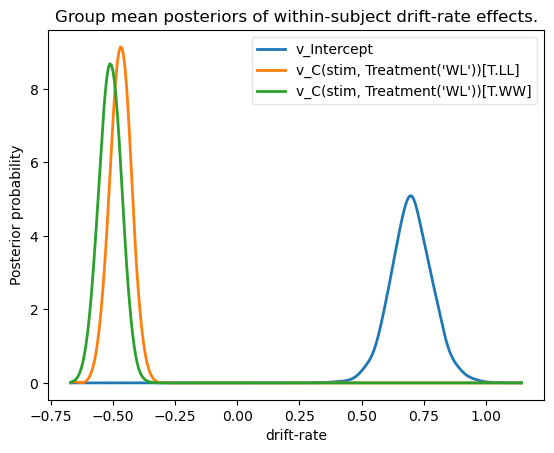

In [31]:
v_WL, v_LL, v_WW = m_reg_all.nodes_db.loc[["v_Intercept",
                                           "v_C(stim, Treatment('WL'))[T.LL]",
                                           "v_C(stim, Treatment('WL'))[T.WW]"], 'node']
hddm.analyze.plot_posterior_nodes([v_WL, v_LL, v_WW])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

## Fitting regression models

In [32]:
m_reg = hddm.HDDMRegressor(data[data.dbs == 0],
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'stim'})
m_reg.sample(5000, burn=1000)

Adding these covariates:
['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]", "a_theta:C(conf, Treatment('LC'))[LC]"]


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [-----------------100%-----------------] 5001 of 5000 complete in 998.6 sec

P(a_theta < 0) =  0.05675


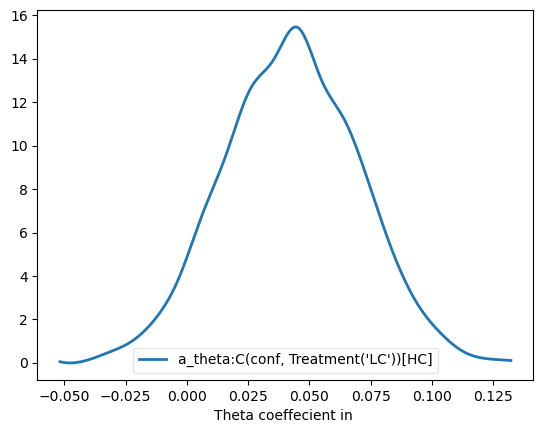

In [33]:
theta = m_reg.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=20)
plt.xlabel('Theta coeffecient in ')
print("P(a_theta < 0) = ", (theta.trace() < 0).mean())

In [34]:
m_reg_off = hddm.HDDMRegressor(data[data.dbs == 1],
                               "a ~ theta:C(conf, Treatment('LC'))",
                               depends_on={'v': 'stim'})
m_reg_off.sample(5000, burn=1000)

Adding these covariates:
['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]", "a_theta:C(conf, Treatment('LC'))[LC]"]


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [-----------------100%-----------------] 5000 of 5000 complete in 971.0 sec

P(a_theta > 0) =  0.0505


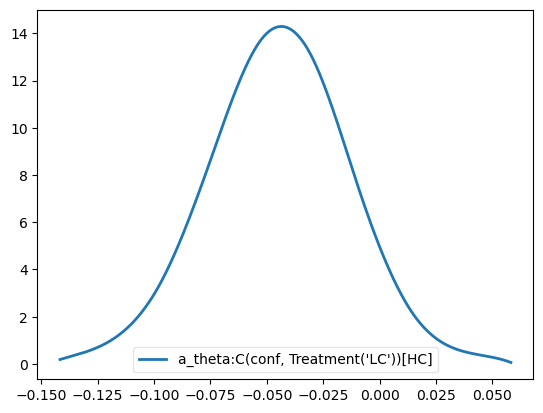

In [35]:
theta = m_reg_off.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=10)
print("P(a_theta > 0) = ", (theta.trace() > 0).mean())

## Dealing with outliers

This part of the tutorial seems outdated because, since 0.6.0, HDDM has a default setting `p_outliers=.05`. 

In [36]:
outlier_data, params = hddm.generate.gen_rand_data(params={'a': 2, 't': .4, 'v': .5},
                                                   size=200, n_fast_outliers=10)

/opt/conda/lib/python3.8/site-packages/hddm/generate.py:683: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.loc[:, 'rt'].iloc[:n_fast] = np.random.rand(
/opt/conda/lib/python3.8/site-packages/hddm/generate.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.loc[:, 'rt'].iloc[n_fast:] = np.random.rand(


In [37]:
m_no_outlier = hddm.HDDM(outlier_data)
m_no_outlier.sample(2000, burn=50)

 [-----------------100%-----------------] 2000 of 2000 complete in 2.2 sec

Text(0, 0.5, 'Probability density')

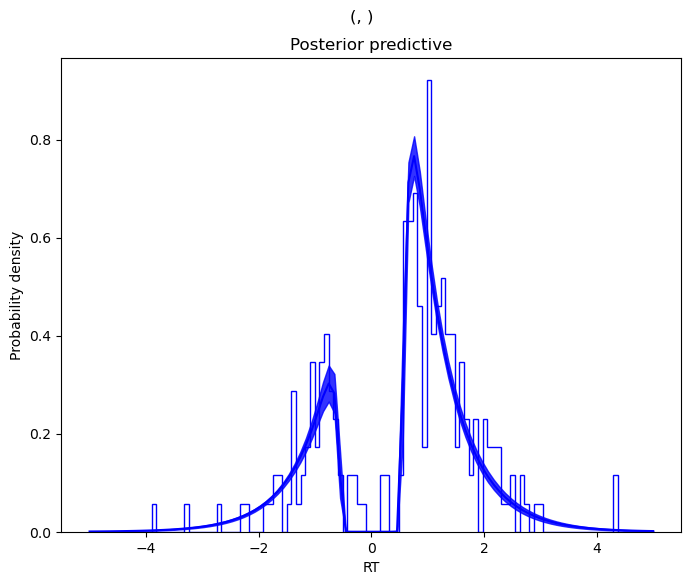

In [38]:
m_no_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_10.pdf')

In [39]:
m_outlier = hddm.HDDM(outlier_data, p_outlier=.05)
m_outlier.sample(2000, burn=20)

 [-----------------100%-----------------] 2000 of 2000 complete in 2.2 sec

Text(0, 0.5, 'Probability density')

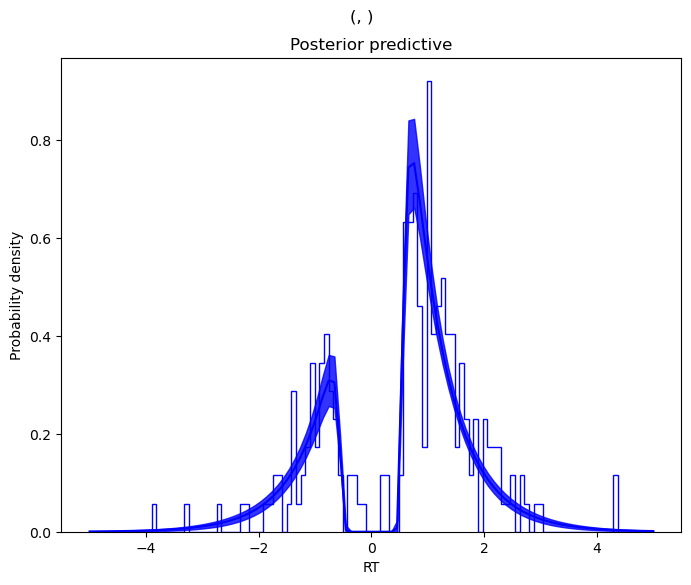

In [40]:
m_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_11.pdf')